# Détectez les Bad Buzz grâce au Deep Learning

### Déscriptif projet

<a href="https://openclassrooms.com/fr/paths/188-ingenieur-ia" target="_blank" style="text-decoration: none; text-align:center;">
    
<img src="./Air_Paradis_Logo.png" style="display:inline-block;max-height: 5rem; max-width: 100%;">
</a>


La société "Air Paradis" souhaite pouvoir détecter les bad buzz via le réseau Twitter. 
Elle souhaite pouvoir détecter les sentiments à partir de jeux de données textuels (Prototype à créer)


Jeu de données: Kaggle : <a href="https://www.kaggle.com/kazanova/sentiment140" target="_blank"> "Sentiment140 dataset with 1.6 miilion tweets"</a> 
 - 1.600.000 tweets labellisés avec un sentiment (négatif ou positif). 
 - Génerer plusieurs solutions: Azure, Custom, ...

6 Champs du fichiers: 

    **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
    **id**: The id of the tweet ( 2087)
    **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
    **flag*: The query (lyx). If there is no query, then this value is NO_QUERY.
    **user**: the user that tweeted (robotickilldozr)
    **text**: the text of the tweet (Lyx is cool)

Dans ce notebook, nous allons utiliser Keras pour créer et entraîner un réseau neuronal qui analyse les sentiments exprimés.

__Données:__

Nous allons utiliser le même jeu de données que sur le notebook précedent (Modèle Simple).

__Traitement des données:__

Nous adapterons le pre-processing des données afin qu'il rende notre modèle neuronal le plus performant possible.
Nous évaluerons ainsi plusieurs méthode des pré-traitement.

__Modèles de Réseaux de Neurones:__

Nous réaliserons plusieurs technique de plongements de mots, et choisierons le modèle le plus performant.
Nous adapterons les hyperparamètres des modèles d'apprentissage, afin de visualiser les variations des scores.
Nous travaillerons sur le seuil de décisions afin de visualiser les variations des résultats.


Les évaluations des modèles seront faites sur des [metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics) provenant de la librairies SickitLearn, tels que:
 - [F1 score](https://en.wikipedia.org/wiki/F1_score) : $\frac{2TP}{2TP + FP + FN} = \frac{2 * precision * recall}{precision + recall}$
 - Recall : $\frac{TP}{TP + FN}$
 - Precision : $\frac{TP}{TP + FP}$
 - Accuracy : $\frac{TP + TN}{Total}$
 - [ROC_AUC](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it)
 
Au regard de la matrice de confusion, l'objectif sera de maximiser l'accuracy (=precision). 
 



## Modèle Sur Mesure avancé

Nous allons ici developper et tester un modèle construit sur un **réseau de neurones**.

Pour ce faire, nous allons :
 1. Lire le fichier
 2. Traiter les données du fichier
 3. Créer et Comparer les résultats de nos réseaux de neurones
 4. Optimiser leur performances

Dans un notebook distinct, nous chercherons à déployer notre meilleur modèle à des fins d'utilisation pour Air Paradis.


In [1]:
#Import functions createdon my side
from Functions_custo_by_Nico import * 

# Import custom helper libraries
import os
import sys

from joblib import dump, load


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential


import preprocessor as p

#import fasttext

In [2]:
# calling functions
Test_Imported_Functions()

Functions have been properly imported !


In [3]:
import sklearn
from sklearn import cluster, metrics, preprocessing, manifold, decomposition, kernel_ridge, linear_model, svm
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay, fbeta_score, precision_recall_curve, make_scorer, plot_roc_curve, mean_squared_error
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVR
from sklearn.utils.class_weight import compute_sample_weight


In [28]:
import datasets
from datasets import load_dataset, Dataset, load_metric

import transformers
#from transformers import *
from transformers import BertTokenizer, AutoTokenizer, DistilBertTokenizerFast, TFBertModel, BertConfig, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, TFTrainer, TFTrainingArguments, TFDistilBertForSequenceClassification, TFAutoModel, TFAutoModelForSequenceClassification, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, create_optimizer


### Lecture du fichier

In [4]:
src_path = os.path.abspath(os.path.join("../IA_Project7_Openclassrooms_BadBuzz_DeepLearning"))
if src_path not in sys.path:
    sys.path.append(src_path)

In [5]:
# Load data from CSV
DATA_URL = os.path.join(src_path, "Dataset", "sentiment140", "training.1600000.processed.noemoticon.csv")
DATASET_COLUMNS = ["target", "id", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
SENTIMENT_MAP = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}

#nrows = 3000



# Using Function load_data = pd.read_csv(DATA_URL, nrows=nrows, names=columns)
df = load_formatted_data(DATA_URL, DATASET_ENCODING, DATASET_COLUMNS) #load_data(DATA_URL, nrows, columns)
df["target_string"] = df["target"].map(lambda x: SENTIMENT_MAP[x])
df["date_format"] = pd.to_datetime(df['date'], format="%a %b %d %H:%M:%S PDT %Y")
df.head()

,target,id,date,flag,user,text,target_string,date_format
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE,2009-04-06 22:19:45
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,NEGATIVE,2009-04-06 22:19:49
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,NEGATIVE,2009-04-06 22:19:53
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,NEGATIVE,2009-04-06 22:19:57
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",NEGATIVE,2009-04-06 22:19:57


### Traitement des données

Ici, le nettoyage consiste à :
 - Remplacer les valeurs Target = 4, à une valeur binaire = 1
 - Techniques de prétraitement du texte
 - Séparation des jeux de données Train, Val et Test 
 - Vectorisation de la chaine de texte = Conversion des textes en séquences 
     - Utilisation du [Tokenizer Keras](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) 
     - Voir [Info stackoverflow](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) 
     - Voir [Tuto Français](https://fr.quish.tv/tutorial-keras-tokenizer)
     - Voir [Exemple Français](https://inside-machinelearning.com/bert-enfin-un-tutoriel-simple-et-rapide/)
 - Padding des sequences = Conversion des séquences en Tableau 2D (Harmonise la longueur des séquences)
      - Utilisation du [pad_sequences Keras](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)
      - Voir [Info stackoverflow](https://stackoverflow.com/questions/42943291/what-does-keras-io-preprocessing-sequence-pad-sequences-do)
 - Transformation des Labels en matrice 2D

<div class="alert alert-block alert-info"><b>
    Tip:
    </b> 
    Attention !!! Dans la cellule ci-dessous, nous reduisons le jeu de donnée à des fins de performance lors de la phase de développement.
</div>


In [6]:
### REDUCTION DU JEU DE DONNEE POUR LES PHASES DE TESTS
#clean_df = clean_data(df.groupby('target').apply(lambda x: x.sample(frac=0.08))) #clean_data(df)
clean_df = df.sample(frac=0.002, random_state=0)
clean_df = clean_df.drop(['id', 'date', 'flag', 'user', 'target_string', 'date_format'], axis=1)


#### Remplacer les valeurs Target

In [7]:
#Replace Target value related to positive statement = 1 (Binary reason)
clean_df.loc[clean_df['target'] == 4, 'target'] = 1

#### Techniques de prétraitement du texte

Nous mettons à disposition ci-dessous 2 techniques différentes de pre-traitement du texte.

 - Technique 1: Pre-traitement customisé: Lowercase, Ponctuation, Stopwords, Charactere spéciaux, Lemmatisation ou Stemmatisation
 - Technique 2: Utilisation de la Librairie [tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/)
 
Dans la suite du Notebook, nous ne conservons uniquement la technique 2, car les résultats obtenus sont plus performants.
En revanche, il est important de noter que nous avons essayer les différentes combinaisons lors de nos phases de tests.

In [8]:
#Technique 2 : Text preprocess using https://pypi.org/project/tweet-preprocessor/
clean_df.text = clean_df.text.apply(lambda x: p.clean(x))

#Technique 1 : Custom text preprocess
#clean_df.text = clean_df.text.apply(lambda x: text_preprocess(x, special_char=True, stem=True, lem=False))


In [9]:
#Custom text preprocess
clean_df.head()

,target,text
557138,0,wants to compete! i want hard competition! i w...
349381,0,It seems we are stuck on the ground in Amarill...
182051,0,where the f are my pinking shears? rarararrrar...
571236,0,ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER M...
1339637,1,reply me pls


#### Séparation des jeux de données Train, Val et Test 

In [9]:
#Séparation des jeux de données
#Define 20% of dataset as Test dataset
X_train, X_test, y_train, y_test = train_test_split(clean_df['text'], clean_df['target'], test_size=0.2, random_state=0, stratify=clean_df['target'])
#Define 20% (=25% * 80%) of dataset as Val dataset, and 60% as Train dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0, stratify=y_train)

#### Vectorisation de la chaine de texte - Tokenisation

In [14]:
tokenizer = Tokenizer(num_words = 1000)
#Sérialisatioon du tokenizer pour une réutilisation future
tokenizer.fit_on_texts(X_train)

dictionary = tokenizer.word_index
vocab_size = len(dictionary) + 1
#print("Vocabulary Size :", vocab_size)



In [160]:
file = open('./Models/tokenizer.pickle','wb')
pickle.dump(tokenizer, file)
file.close()
#save vectoriser_stem model in joblib files
dump(tokenizer, './Models/tokenizer.joblib')

['./Models/tokenizer.joblib']

In [16]:
X_train_enc = tokenizer.texts_to_sequences(X_train)
X_test_enc = tokenizer.texts_to_sequences(X_test)

#Visualisation des 2 premières sequences, après transformation des mots en identifiant
#X_train_enc[:2]

Nous avons initialisé le tokenizer en définissant le nombre de mots maximum à conserver.

Nous réutiliserons ce tokenizer pour tous nos traitements de données à venir.

#### Conversion des séquences en Tableau 2D (Harmonise la longueur des séquences)


In [17]:

#Nous définissons la longueur des séquences (Ici 30 Mots)
maxlen = 30

X_train_ready = pad_sequences(X_train_enc, maxlen = maxlen, padding='post')
X_test_ready = pad_sequences(X_test_enc, maxlen = maxlen, padding='post')

In [70]:
print("Training X_train_ready Shape:",X_train_ready.shape)
print("Testing X_test_ready Shape:",X_test_ready.shape)

Training X_train_ready Shape: (192000, 30)
Testing X_test_ready Shape: (64000, 30)


Les données textuelles sont maintenant prêtes.

#### Transformation des Labels en matrice 2D
Afin de satisfaire à l'utilisation de la librairie Keras, nous transformons les labels en 2D.


In [18]:
y_train = np.asarray(y_train).astype('float32').reshape(-1,1)
y_test = np.asarray(y_test).astype('float32').reshape(-1,1)

In [71]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (192000, 1)
y_test shape: (64000, 1)


In [72]:
# # Buffer les datas en mémoire (pour amélioration des performances)
# X_train_cache = X_train_ready.cache().prefetch(buffer_size=10)
# #val_ds = val_ds.cache().prefetch(buffer_size=10)
# X_test_cache = X_test_ready.cache().prefetch(buffer_size=10)

## Les Modèles de réseau de neurones

Il y a [2 types de réseau de neurones](https://www.lemagit.fr/conseil/Reseaux-de-neurones-RNN-et-CNN-comment-les-differencier)
 - Réseau de neurones convolutifs ([Wiki CNN](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif)) -
 - Réseau de neurones récurrent ([Wiki RNN](https://fr.wikipedia.org/wiki/R%C3%A9seau_de_neurones_r%C3%A9currents)) - [Blog](https://datavalue-consulting.com/deep-learning-reseaux-neurones-recurrents-rnn/) - [Blog](https://datascientest.com/recurrent-neural-network)
 
Dans notre cas, nous developperons les Réseau de neurones récurrent, au travers de [5 étapes](https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/):

    1. Architecture du modèle
    2. Compilation du modèle et choix de la métrique
    3. Entrainement du modèle (voir Callbacks définis ci-après)
    4. Evaluation du modèle
    5. Prédiction du modèle

Les évaluations des modèles seront faites sur des [metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics) provenant de la librairies SickitLearn, tels que:
 - [F1 score](https://en.wikipedia.org/wiki/F1_score) : $\frac{2TP}{2TP + FP + FN} = \frac{2 * precision * recall}{precision + recall}$
 - Recall : $\frac{TP}{TP + FN}$
 - Precision : $\frac{TP}{TP + FP}$
 - Accuracy : $\frac{TP + TN}{Total}$
 - [ROC_AUC](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it)
 
Au regard du jeu de donnée qui parait équilibré en évaluation positive et négative, et des résultats de la matrice de confusion, **l'objectif sera de maximiser l'accuracy**. 


### Pré-requis : Définition des Callbacks

Avant l’entraînement de chacun de nos modèles avec la fonction fit(), nous allons créer un callback (enregistrement). Cette fonction permet de sauvegarder en mémoire les résultats de notre modèle à chaque epoch en les enregistrant dans notre dossier précédemment créé.

Voir [Callbacks de Keras](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)

   - [Early_Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
   - [Model Chackpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)
   - [Reduce LR On Plateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)
    

In [66]:
#L'arrêt précoce consiste à arrêter l'entraînement dès que les pertes commencent à augmenter 
#(ou, en d'autres termes, que la précision de la validation commence à diminuer).
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', #Contrôlez la perte de validation
                                               min_delta=0, #seuil permettant de quantifier une perte à une certaine époque
                                               patience=3, #eprésente le nombre d'époques avant de s'arrêter
                                               verbose=1,
                                               mode='min' #surveillons la perte, nous pouvons utiliser la fonction min
                                              )

#Sauvegarde du meilleur modèle
mode_autosave = keras.callbacks.ModelCheckpoint('./Models/checkpoint',
                                                monitor="val_accuracy",                                                   
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                #save_freq="epoch",
                                                #options=None,
                                                #initial_value_threshold=None,
                                                mode="max"
                                               )


#Diminution automatique du learning rate quand la val_loos ne progresses plus
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.1,
                                                  patience=3, #number of epochs with no improvement after which learning rate will be reduced. 
                                                  verbose=1, 
                                                  mode='min', #learning rate will be reduced when the quantity monitored has stopped decreasing
                                                  #min_delta=0.0001,
                                                  cooldown=3, #number of epochs to wait before resuming
                                                  min_lr=0.1e-5 #lower bound on the learning rate. 
                                                 )

callbacks = [early_stopping, mode_autosave, lr_reducer]

### Rappel: Définition d'un Word Emdedding

Le word embedding désigne un ensemble de méthode d’apprentissage visant à représenter les mots d’un texte par des vecteurs de nombres réels.
Le word embedding est capable en réduisant la dimension de capturer le contexte, la similarité sémantique et syntaxique (genre, synonymes, …) d’un mot. 

De façon basique, il permet la représentation des mots par des vecteurs (distance dans un espace).

Nous allons suivre cette étape d'embedding, **au travers de 2 méthodologies de plongements différentes**:

A. Modèle sans pré-Entrainement:
 1. 1D ConvNet (Modèle 1)
 2. Bi-LSTBM (Modèle 2)

B. Modèle avec pré-Entrainement (Transfer Learning) :
 - [GloVe](https://nlp.stanford.edu/projects/glove/) 
     1. Sans Mise à jour des plongements (Modèle 3)
     2. Avec Mise à jour des plongements (Modèle 4)
     
     
 - [Fasttext](https://fasttext.cc/) 
     3. Sans Mise à jour des plongements (Modèle 6)
     4. Avec Mise à jour des plongements (Modèle 8)
     
     
 - [Word2Vec](https://fr.wikipedia.org/wiki/Word2vec) (Non-intégré au Notebook)


Nous comparerons les résultats de chacunne de ces methodlogies et modèle.
Une fois le meilleur scénario obtenu, nous conserverons le plus performant pour un déploiement.

_Note: L'analyse dun apport en performance grace à un modèle BERT sera étudié dans le notebook distinct_


Quelques documentations utiles:

 - Voir [Word2Vec Francais](https://datascientest.com/nlp-word-embedding-word2vec)
 - Voir [Blog enseignement](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/ml2a/td2a_mlplus_traitement_du_langage.html)
 - Voir [Vidéo Word Embedding](https://www.youtube.com/watch?v=3KQG24jBpHg) - durée 36min
 - Voir [Vidéo Couche Embedding de Keras](https://www.youtube.com/watch?v=JNA5vxmBKJw) - durée 41min
 - Voir [Kaggle explicatif](https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer)
 - Voir [exemples Machine Learning Web](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)


## A.1. Modèle sans pré-Entrainement -  1D convnet avec Embedding layer.
### A.1.1. Architecture du modèle
Utilisation de la librairies Keras de Tensorflow ([Voir Doc Keras ConvNet](https://keras.io/api/layers/convolution_layers/convolution1d/)).

Nous allons appliquer les couches successives sur nos données d'entrées ([voir Exemple Keras](https://keras.io/examples/nlp/text_classification_from_scratch/))

Nous définisson l'achitecture du modèle RNN [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814651-decouvrez-le-fonctionnement-des-reseaux-de-neurones-recurrents#/id/r-6147743)

In [73]:
model_name="1. 1D ConvNet"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# Embed each integer in a 256-dimensional vector
x = layers.Embedding(vocab_size, 256)(inputs) #Vector size = 256, reprenseting each word of sequences
x = layers.Dropout(0.5)(x) #Improve performance of the model

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x) #sigoid = probabilités

model_ConvNet = tf.keras.Model(inputs, predictions)

### A.1.2. Compilation du modèle et choix de la métrique
Nous utilisons la méthode d'optimisiation [adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), qui effectue une descente de gradient.

In [74]:
# Compile the model with binary crossentropy loss and an adam optimizer.
model_ConvNet.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #'mean_squared_error' si problème de regression

#sparse_categorical_crossentropy

#model_ConvNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=tf.metrics.SparseCategoricalAccuracy(),
#             )

# summarize the model
print(model_ConvNet.summary())

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 256)         20707584  
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         229504    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [75]:
# compile the model
#model_ConvNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
#print(model_ConvNet.summary())

### A.1.3. Entrainement du modèle

In [77]:
epochs = 10 #(epochs = Nombre de parcours de phase d'apprentissage)

# Fit the model using the train and test datasets.
history = model_ConvNet.fit(X_train_ready, y_train, 
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_ready, y_test),
                    batch_size = 128,
                    callbacks = callbacks,
                    workers = 3
                   )

model_ConvNet.save(model_file_path)


Epoch 00001: val_accuracy improved from -inf to 0.77089, saving model to ./Models\checkpoint

Epoch 00002: val_accuracy improved from 0.77089 to 0.77498, saving model to ./Models\checkpoint

Epoch 00003: val_accuracy improved from 0.77498 to 0.78025, saving model to ./Models\checkpoint

Epoch 00004: val_accuracy did not improve from 0.78025

Epoch 00005: val_accuracy did not improve from 0.78025

Epoch 00006: val_accuracy did not improve from 0.78025

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00006: early stopping


### A.1.4. Evaluation du modèle

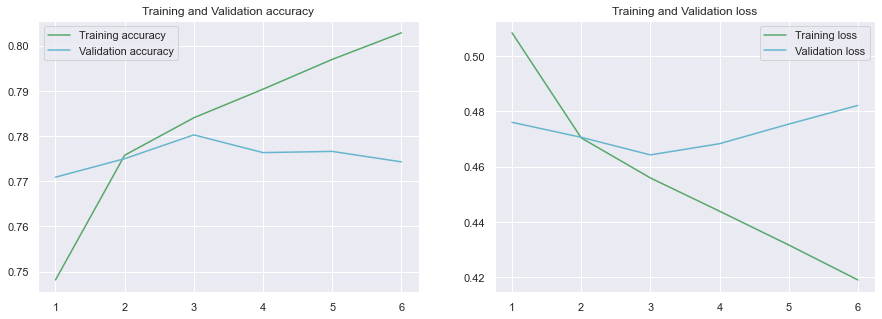

In [78]:
plot_history(history)

Nous notons ici qu'il y a bien un risque de sur-apprentissage, à la vue de l'écart qui se créé.

Ce modèle réussit bien à apprendre avec une précision qui s'approche des 80% en 5 Epochs.
La précision de Validation augmente pendant 3 Epochs, puis se stabilise.

Au delà de 3 Epochs, le risque de sur-apprentissage est croissant, et les explications communes sont:

    - Erreur de Code (Fuite de données)
    - Sur-Apprentissage dû à des différences entre les jeux de données d'entrainement et de validation
    - Classification aléatoire (changeantes entre  les jeux de données d'entrainement et de validation)

Voir l'article [StackOverflow](https://stackoverflow.com/questions/44616841/what-does-it-mean-when-train-and-validation-loss-diverge-from-epoch-1)

In [79]:
# evaluate the model
loss, accuracy = model_ConvNet.evaluate(X_test_ready, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

Accuracy: 77.428126
Loss: 48.209625


### A.1.5. Prédiction et Performance du modèle

In [80]:
y_prob = model_ConvNet.predict(X_test_ready)
y_pred = np.where(y_prob > 0.5, 1, 0)
y_pred = y_pred.astype(int)
y_prob
y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [72]:
#Initialisation de la table des résultats
score_column_names = ["Model Type","Model Name","seuil","F1-Score","FBeta-Score", "Recall_score", "Precision_score", "Accuracy_score", "Roc_AUC_score"]
store_score = pd.DataFrame(columns = score_column_names)


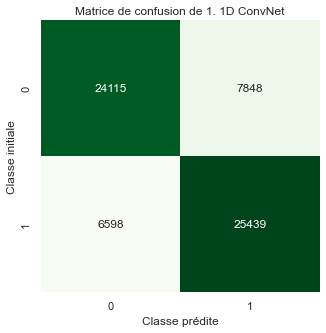

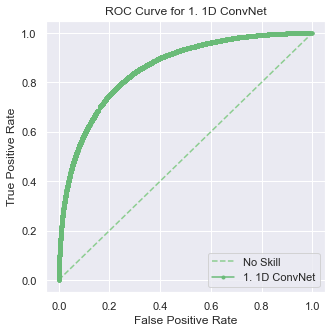

In [82]:
seuil=0.5
binary_transform = True

score_results_stored = evaluation(model_ConvNet, model_name, score_column_names, X_test_ready, y_test, seuil = 0.5, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)


In [83]:
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,<tensorflow.python.keras.engine.functional.Fun...,1. 1D ConvNet,0.5,0.778856,0.770015,0.794051,0.764232,0.774281,0.857541


### A.1.6 Optimisation du  seuil de décision

In [84]:
thresholds_column_names = ["Model Type","Model Name","seuil","beta","F1_score","FBeta-Score","Roc_AUC_score", "Recall_score", "Precision_score", "Accuracy_score", "tn", "fp", "fn", "tp"]


20/20 [==============================] - 3s 168ms/step
Roc_AUC_score = 0.9172863142778513


C:\Users\blanc\anaconda3\envs\IA_Project7_Sentiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The optimized threshold for Accuracy is : [0.5172413793103449]


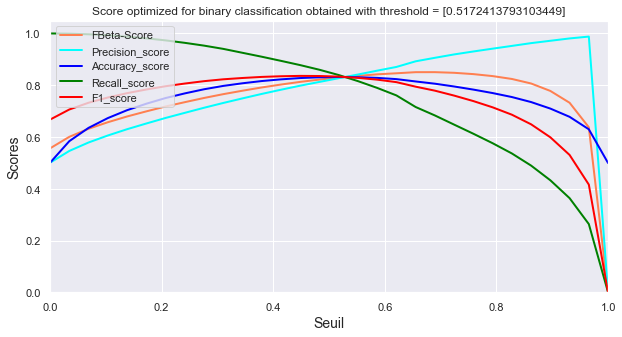

In [85]:
store_score_thresholds = pd.DataFrame(columns = thresholds_column_names)
seuils = np.linspace(0.0, 1.0, num = 30)
store_score_thresholds = predict_threshold(model_ConvNet,model_name,thresholds_column_names,X_train_ready,y_train,seuils, beta = 0.5, binary_predict=False, predict_proba_OK=False)

In [86]:
store_score_thresholds.loc[(store_score_thresholds['Accuracy_score'] == store_score_thresholds['Accuracy_score'].max()), 'seuil'].values

array([0.5172413793103449], dtype=object)

Nous avons donc conçu un premier embedding sur la base de l'algoithme ConvNet.
Nous poursuivons ci-dessous avec un autre embedding LSTM.

## A.2. Modèle sans pré-Entrainement -  LSTM bidirectionnel
### A.2.1. Architecture du modèle
Utilisation de la librairies Keras de Tensorflow

Nous allons appliquer les couches successives sur nos données d'entrées ([voir Doc Keras et exemple Bidirectional LTSM](https://keras.io/examples/nlp/bidirectional_lstm_imdb/))

 - Voir aussi [Tutorial LSTM Sequential](https://www.embedded-robotics.com/sentiment-analysis-using-lstm/)
 - Voir aussi [Tutorial LSTM Sequential Bidirectional](https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/)


Nous définisson l'achitecture du modèle RNN:

1) Embedding Layer - Générer les vecteurs de plongements de mots pour chaque sequence.

3) Conv1D Layer - Couche de convolution permettant de concentrer l'information, et d'apprendre des représentations. [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814661-construisez-des-architectures-neuronales-modulaires#/id/r-6231514)

4) Bi-LSTM - Long Short Term Memory - Réseau de Neurones Récurrentes utile pour l'analyse de séquence multidirectionnelle, capable de modéliser des dépendances à travers le temps [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814656-decouvrez-les-cellules-a-memoire-interne-les-lstm#/id/r-6353610)

4) Dense - Fully Connected Layers - Couche nécessaire à la prise de décision [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814661-construisez-des-architectures-neuronales-modulaires#/id/r-6185547)


In [89]:
model_name="2. LTSM Bidirect"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

# A integer input for vocab indices.
#inputs = tf.keras.Input(shape=(None,), dtype="int64")
inputs = tf.keras.Input(shape=(maxlen,), dtype='int32')

# Next, we add a layer to map those vocab indices into a space of dimensionality
# Embed each integer in a 256-dimensional vector
#x = layers.Embedding(vocab_size, 256)(inputs) #Vector size = 256, reprenseting each word of sequences
#embedding_sequences = embedding_layer(sequence_input)
sequences = layers.Embedding(vocab_size, 256)(inputs)

x = layers.SpatialDropout1D(0.2)(sequences)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# Add 2 bidirectional LSTMs
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x) #(1, activation='sigmoid')

predictions = layers.Dense(1, activation='sigmoid')(x)



model_LTSM = keras.Model(inputs, predictions)

model_LTSM.summary()


Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 30, 256)           20707584  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 256)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 26, 64)            81984     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

### A.2.2. Compilation du modèle et choix de la métrique
Nous utilisons la méthode d'optimisiation [adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), qui effectue une descente de gradient.

In [90]:
# Compile the model with binary crossentropy loss and an adam optimizer.
model_LTSM.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #'mean_squared_error' si problème de regression

#model_LTSM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=tf.metrics.SparseCategoricalAccuracy(),
#             )

# summarize the model
print(model_LTSM.summary())



Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 30, 256)           20707584  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 256)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 26, 64)            81984     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

### A.2.3. Entrainement du modèle

In [91]:
#model_LTSM.fit(X_train_ready, y_train, batch_size=32, epochs=2, validation_data=(X_test_ready, y_test))

epochs = 10 #(epochs = Nombre de parcours de phase d'apprentissage)

# Fit the model using the train and test datasets.
history = model_LTSM.fit(X_train_ready, y_train, 
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_ready, y_test),
                    batch_size = 128,
                    callbacks = callbacks,
                    workers = 3
                   )

model_LTSM.save(model_file_path)


Epoch 00001: val_accuracy did not improve from 0.78025

Epoch 00002: val_accuracy improved from 0.78025 to 0.78338, saving model to ./Models\checkpoint

Epoch 00003: val_accuracy improved from 0.78338 to 0.78519, saving model to ./Models\checkpoint

Epoch 00004: val_accuracy did not improve from 0.78519

Epoch 00005: val_accuracy did not improve from 0.78519

Epoch 00006: val_accuracy did not improve from 0.78519

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00006: early stopping


### A.2.4. Evaluation du modèle

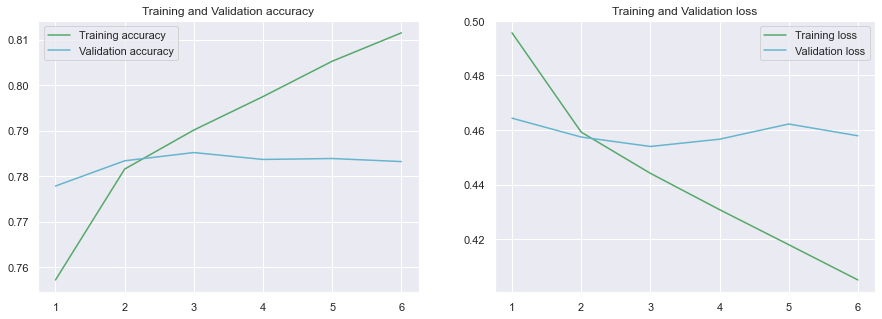

In [92]:
plot_history(history)

Nous notons ici qu'il y a bien un risque de sur-apprentissage, à la vue de l'écart qui se créé.

Ce modèle réussit bien à apprendre avec une précision qui s'approche des 80% en 4 Epochs.
La précision de Validation augmente pendant 2 Epochs, puis se stabilise.

Au delà de 2 Epochs, le risque de sur-apprentissage est croissant, et les explications communes sont:

    - Erreur de Code (Fuite de données)
    - Sur-Apprentissage dû à des différences entre les jeux de données d'entrainement et de validation
    - Classification aléatoire (changeantes entre  les jeux de données d'entrainement et de validation)

Voir l'article [StackOverflow](https://stackoverflow.com/questions/44616841/what-does-it-mean-when-train-and-validation-loss-diverge-from-epoch-1)

In [93]:
# evaluate the model
loss, accuracy = model_LTSM.evaluate(X_test_ready, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

Accuracy: 78.320312
Loss: 45.791841


### A.2.5. Prédiction et performance du modèle

In [94]:
y_prob = model_LTSM.predict(X_test_ready)
y_pred = np.where(y_prob > 0.5, 1, 0)
y_pred = y_pred.astype(int)
y_prob
y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

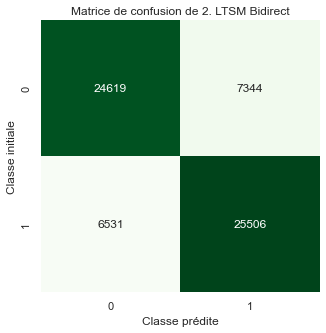

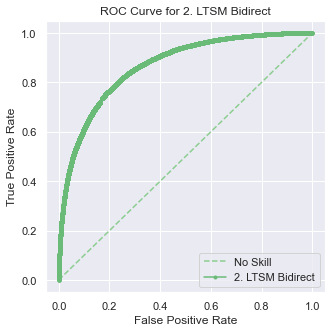

In [95]:
seuil=0.5
binary_transform = True

score_results_stored = evaluation(model_LTSM, model_name, score_column_names, X_test_ready, y_test, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)


In [96]:
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,<tensorflow.python.keras.engine.functional.Fun...,1. 1D ConvNet,0.5,0.778856,0.770015,0.794051,0.764232,0.774281,0.857541
1,<tensorflow.python.keras.engine.functional.Fun...,2. LTSM Bidirect,0.5,0.786167,0.780301,0.796142,0.776438,0.783203,0.867276


### A.2.6. Optimisation du seuil de décision

20/20 [==============================] - 14s 713ms/step
Roc_AUC_score = 0.9193277640557054


C:\Users\blanc\anaconda3\envs\IA_Project7_Sentiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The optimized threshold for Accuracy is : [0.5172413793103449]


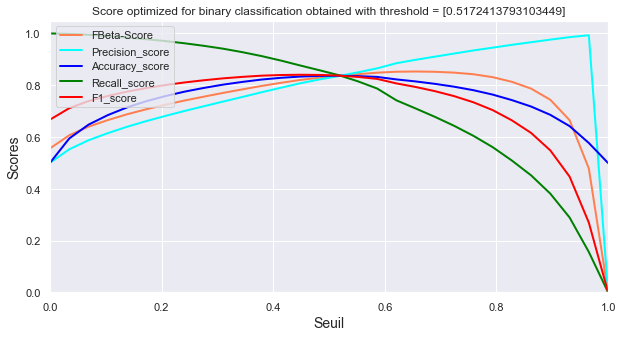

In [98]:
store_score_thresholds = pd.DataFrame(columns = thresholds_column_names)
seuils = np.linspace(0.0, 1.0, num = 30)
store_score_thresholds = predict_threshold(model_LTSM,model_name,thresholds_column_names,X_train_ready,y_train,seuils, beta = 0.5, binary_predict=False, predict_proba_OK=False)

In [99]:
store_score_thresholds.loc[(store_score_thresholds['Accuracy_score'] == store_score_thresholds['Accuracy_score'].max()), 'seuil'].values

array([0.5172413793103449], dtype=object)

## Conclusion des modèle sans pré-entrainement:

Nous avons comparé les performances de 2 modèles sans pré-entrainement des plongements.
Nous observons que le **modèle Bi-LSTM est plus performant** dans notre cas d'utilisation. 

Nous le conserverons pour la suite de notre étude.

## B.1. Modèle avec pré-Entrainement  - Transfer Learning à partir du Modèle Glove - Sans Mise à jour des plongements

Nous allons ici utilisé des Embeddings pré-entrainé:

Voir [Doc Keras](https://keras.io/examples/nlp/pretrained_word_embeddings/)
Voir [Doc](https://realpython.com/python-keras-text-classification/#using-pretrained-word-embeddings)

Librairies  utilisée: [Librairie Glove](https://nlp.stanford.edu/projects/glove/)
 
Autres librairies non-sollicitées ici:
 - [FastText](https://fasttext.cc/)
 - [Cours OC](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855006-effectuez-des-plongements-de-mots-word-embeddings)

### B.x.0. Chargement du Word Embedding (Plongement des mots) Glove pré-entrainé


In [12]:
#Glove: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#load the entire GloVe word embedding file into memory as a dictionary of word to embedding array

embeddings_index_Glove = dict()
DATA_GLOVE = os.path.join(src_path, "Pre-Trained_Embedding", "glove.twitter.27B", "glove.twitter.27B.100d.txt")
Glove_File = open(DATA_GLOVE, encoding="utf8")
for line in Glove_File:
    values_Glove = line.split()
    word_Glove = values_Glove[0]
    coefs_Glove = np.asarray(values_Glove[1:], dtype='float32')
    embeddings_index_Glove[word_Glove] = coefs_Glove
Glove_File.close()
print('Loaded %s word vectors.' % len(embeddings_index_Glove))

Loaded 1193514 word vectors.


In [187]:
# create a matrix of one embedding for each word in the training dataset
embedding_matrix_Glove = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector_Glove = embeddings_index_Glove.get(word)
    if embedding_vector_Glove is not None:
        embedding_matrix_Glove[i] = embedding_vector_Glove

In [188]:
#embedding_matrix

In [189]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_Glove, axis=1))
nonzero_elements / vocab_size

0.5320115777687782

Nous vérifions ci-dessus le % de vecteurs de plongements connus dans le modèle pré-entrainé.

Il est de 66 %

### B.1.1. Architecture du modèle
Nous définisson l'achitecture du modèle RNN, comme nous l'avions fait précedemment:

1) Embedding Layer - Générer les vecteurs de plongements de mots pour chaque sequence.

3) Conv1D Layer - Couche de convolution permettant de concentrer l'information, et d'apprendre des représentations. [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814661-construisez-des-architectures-neuronales-modulaires#/id/r-6231514)

4) Bi-LSTM - Long Short Term Memory - Réseau de Neurones Récurrentes utile pour l'analyse de séquence multidirectionnelle, capable de modéliser des dépendances à travers le temps [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814656-decouvrez-les-cellules-a-memoire-interne-les-lstm#/id/r-6353610)

4) Dense - Fully Connected Layers - Couche nécessaire à la prise de décision [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814661-construisez-des-architectures-neuronales-modulaires#/id/r-6185547)


Dans l'exemple ci-dessous, nous n'entrainons pas nos plongements à partir du jeu de données de Tweeter.

In [104]:
model_name="3. Glove Pre-trained embedding"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

# A integer input for vocab indices.
#inputs = tf.keras.Input(shape=(None,), dtype="int64")
inputs = tf.keras.Input(shape=(maxlen,), dtype='int32')
sequences = layers.Embedding(vocab_size, 100, weights=[embedding_matrix_Glove], input_length=maxlen, trainable=False)(inputs)

x = layers.SpatialDropout1D(0.2)(sequences)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# Add 2 bidirectional LSTMs
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x) #(1, activation='sigmoid')

predictions = layers.Dense(1, activation='sigmoid')(x)

model_Glove = keras.Model(inputs, predictions)

model_Glove.summary()


Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 30, 100)           8088900   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 100)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 26, 64)            32064     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_9 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)             

### B.1.2. Compilation du modèle et choix de la métrique
Nous utilisons la méthode d'optimisiation [adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), qui effectue une descente de gradient.

In [105]:
# Compile the model with binary crossentropy loss and an adam optimizer.
model_Glove.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #'mean_squared_error' si problème de regression

#model_Glove.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=tf.metrics.SparseCategoricalAccuracy(),
#             )

# summarize the model
print(model_Glove.summary())


Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 30, 100)           8088900   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 30, 100)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 26, 64)            32064     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_9 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)             

### B.1.3. Entrainement du modèle

In [106]:
epochs = 10 #(epochs = Nombre de parcours de phase d'apprentissage)

# Fit the model using the train and test datasets.
history = model_Glove.fit(X_train_ready, y_train, 
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_ready, y_test),
                    #batch_size = 128,
                    callbacks = callbacks,
                    workers = 3
                   )

model_Glove.save(model_file_path)


Epoch 00001: val_accuracy did not improve from 0.78519

Epoch 00002: val_accuracy did not improve from 0.78519

Epoch 00003: val_accuracy did not improve from 0.78519

Epoch 00004: val_accuracy did not improve from 0.78519

Epoch 00005: val_accuracy did not improve from 0.78519

Epoch 00006: val_accuracy did not improve from 0.78519

Epoch 00007: val_accuracy did not improve from 0.78519

Epoch 00008: val_accuracy did not improve from 0.78519

Epoch 00009: val_accuracy did not improve from 0.78519

Epoch 00010: val_accuracy did not improve from 0.78519


### B.1.4. Evaluation du modèle

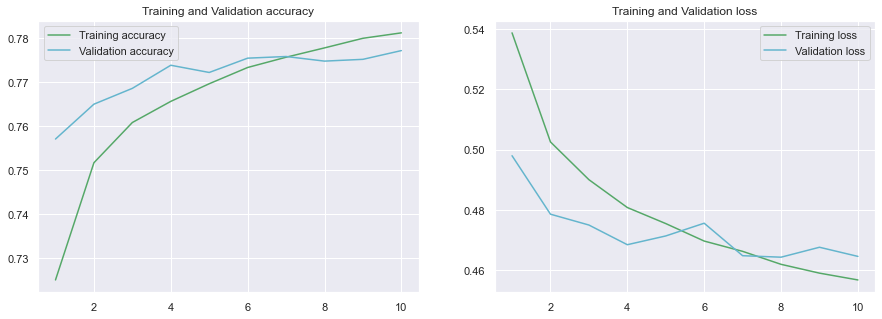

In [107]:
plot_history(history)

Nous avons résolu ici le pbm de sur-apprentissage.

Ce modèle réussit bien à apprendre avec une précision qui s'approche des 80% en 10 Epochs.
La précision de Validation augmente pendant 8 Epochs, puis se stabilise.

Il s'agit pour le moment du modèle le plus rassurant, au regard des pertes et de l'accuracy.

Voir l'article [StackOverflow](https://stackoverflow.com/questions/44616841/what-does-it-mean-when-train-and-validation-loss-diverge-from-epoch-1)

In [108]:
# evaluate the model
loss, accuracy = model_Glove.evaluate(X_test_ready, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

Accuracy: 77.714062
Loss: 46.457613


### B.1.5. Prédiction et Performance du modèle

In [109]:
y_prob = model_Glove.predict(X_test_ready)
y_pred = np.where(y_prob > 0.5, 1, 0)
y_pred = y_pred.astype(int)
y_prob
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

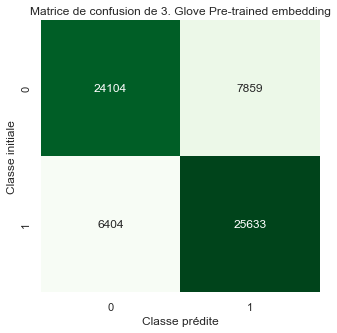

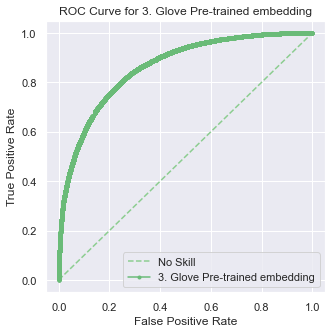

In [110]:
seuil=0.5
binary_transform = True

score_results_stored = evaluation(model_Glove, model_name, score_column_names, X_test_ready, y_test, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)


In [111]:
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,<tensorflow.python.keras.engine.functional.Fun...,1. 1D ConvNet,0.5,0.778856,0.770015,0.794051,0.764232,0.774281,0.857541
1,<tensorflow.python.keras.engine.functional.Fun...,2. LTSM Bidirect,0.5,0.786167,0.780301,0.796142,0.776438,0.783203,0.867276
2,<tensorflow.python.keras.engine.functional.Fun...,3. Glove Pre-trained embedding,0.5,0.782341,0.772055,0.800106,0.765347,0.777141,0.862803


### B.1.6 Optimisation du seuil de décision

20/20 [==============================] - 12s 583ms/step
Roc_AUC_score = 0.8887497367931322


C:\Users\blanc\anaconda3\envs\IA_Project7_Sentiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The optimized threshold for Accuracy is : [0.5172413793103449]


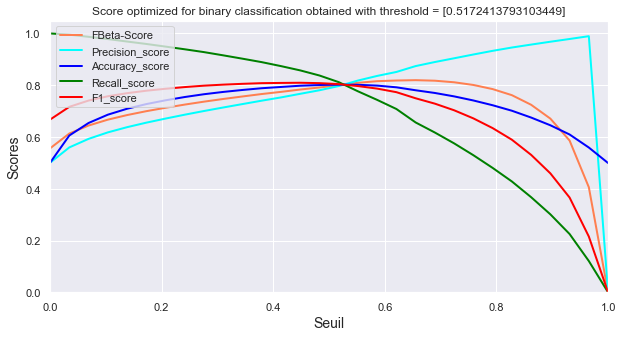

In [112]:
store_score_thresholds = pd.DataFrame(columns = thresholds_column_names)
seuils = np.linspace(0.0, 1.0, num = 30)
store_score_thresholds = predict_threshold(model_Glove,model_name,thresholds_column_names,X_train_ready,y_train,seuils, beta = 0.5, binary_predict=False, predict_proba_OK=False)

In [113]:
store_score_thresholds.loc[(store_score_thresholds['Accuracy_score'] == store_score_thresholds['Accuracy_score'].max()), 'seuil'].values

array([0.5172413793103449], dtype=object)

In [114]:
#store_score_thresholds

## B.2. Modèle avec pré-Entrainement  - Transfer Learning à partir du Modèle Glove - Avec Mise à jour des plongements
Dans la suite de l'exercice, nous allons mettre à jour nos plongements (embedding), avec le LSTM vu précedemment.

### B.2.1. Architecture du modèle


In [115]:
model_name="4. Glove Re-trained embedding Bi-LSTM"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

# A integer input for vocab indices.
#inputs = tf.keras.Input(shape=(None,), dtype="int64")
inputs = tf.keras.Input(shape=(maxlen,), dtype='int32')
sequences = layers.Embedding(vocab_size, 100, weights=[embedding_matrix_Glove], input_length=maxlen, trainable=True)(inputs)

x = layers.SpatialDropout1D(0.2)(sequences)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# Add 2 bidirectional LSTMs
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x) #(1, activation='sigmoid')

predictions = layers.Dense(1, activation='sigmoid')(x)

model_Glove_updated = keras.Model(inputs, predictions)

model_Glove_updated.summary()


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 30, 100)           8088900   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 30, 100)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 26, 64)            32064     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)             

### B.2.2. Compilation du modèle et choix de la métrique
Nous utilisons la méthode d'optimisiation [adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), qui effectue une descente de gradient.

In [116]:
# Compile the model with binary crossentropy loss and an adam optimizer.
model_Glove_updated.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #'mean_squared_error' si problème de regression

#model_Glove.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=tf.metrics.SparseCategoricalAccuracy(),
#             )

# summarize the model
print(model_Glove_updated.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 30, 100)           8088900   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 30, 100)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 26, 64)            32064     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)             

### B.2.3. Entrainement du modèle

In [117]:
epochs = 10 #(epochs = Nombre de parcours de phase d'apprentissage)

# Fit the model using the train and test datasets.
history = model_Glove_updated.fit(X_train_ready, y_train, 
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_ready, y_test),
                    #batch_size = 128,
                    callbacks = callbacks,
                    workers = 3
                   )

model_Glove_updated.save(model_file_path)


Epoch 00001: val_accuracy did not improve from 0.78519

Epoch 00002: val_accuracy did not improve from 0.78519

Epoch 00003: val_accuracy improved from 0.78519 to 0.78591, saving model to ./Models\checkpoint

Epoch 00004: val_accuracy did not improve from 0.78591

Epoch 00005: val_accuracy improved from 0.78591 to 0.78864, saving model to ./Models\checkpoint

Epoch 00006: val_accuracy did not improve from 0.78864

Epoch 00007: val_accuracy did not improve from 0.78864

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00007: early stopping


### B.2.4. Evaluation du modèle

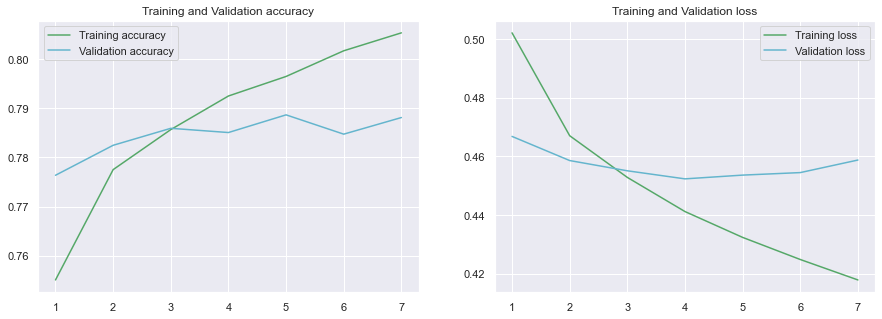

In [118]:
plot_history(history)

Nous notons ici qu'il y a bien un risque de sur-apprentissage, à la vue de l'écart qui se créé.

Ce modèle réussit bien à apprendre avec une précision qui s'approche des 80% en 5 Epochs.
La précision de Validation augmente pendant 4 Epochs, puis se stabilise.

Au delà de 4 Epochs, le risque de sur-apprentissage est croissant, et les explications communes sont:

    - Erreur de Code (Fuite de données)
    - Sur-Apprentissage dû à des différences entre les jeux de données d'entrainement et de validation
    - Classification aléatoire (changeantes entre  les jeux de données d'entrainement et de validation)

Voir l'article [StackOverflow](https://stackoverflow.com/questions/44616841/what-does-it-mean-when-train-and-validation-loss-diverge-from-epoch-1)

In [119]:
# evaluate the model
loss, accuracy = model_Glove_updated.evaluate(X_test_ready, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

Accuracy: 78.809375
Loss: 45.868212


### B.2.5. Prédiction et Performance du modèle

In [120]:
y_prob = model_Glove_updated.predict(X_test_ready)
y_pred = np.where(y_prob > 0.5, 1, 0)
y_pred = y_pred.astype(int)
y_prob
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

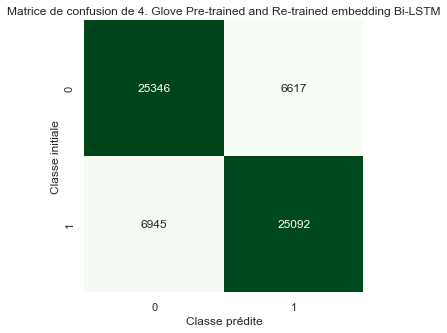

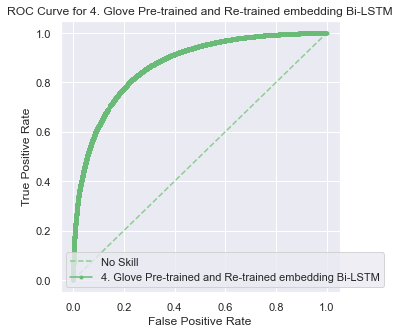

In [121]:
seuil=0.5
binary_transform = True

score_results_stored = evaluation(model_Glove_updated, model_name, score_column_names, X_test_ready, y_test, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)


In [122]:
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,<tensorflow.python.keras.engine.functional.Fun...,1. 1D ConvNet,0.5,0.778856,0.770015,0.794051,0.764232,0.774281,0.857541
1,<tensorflow.python.keras.engine.functional.Fun...,2. LTSM Bidirect,0.5,0.786167,0.780301,0.796142,0.776438,0.783203,0.867276
2,<tensorflow.python.keras.engine.functional.Fun...,3. Glove Pre-trained embedding,0.5,0.782341,0.772055,0.800106,0.765347,0.777141,0.862803
3,<tensorflow.python.keras.engine.functional.Fun...,4. Glove Pre-trained and Re-trained embedding ...,0.5,0.787249,0.789687,0.783219,0.791321,0.788094,0.871671


### B.2.6 Optimisation du seuil de décision

20/20 [==============================] - 14s 678ms/step
Roc_AUC_score = 0.8887497367931322


C:\Users\blanc\anaconda3\envs\IA_Project7_Sentiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The optimized threshold for Accuracy is : [0.5172413793103449]


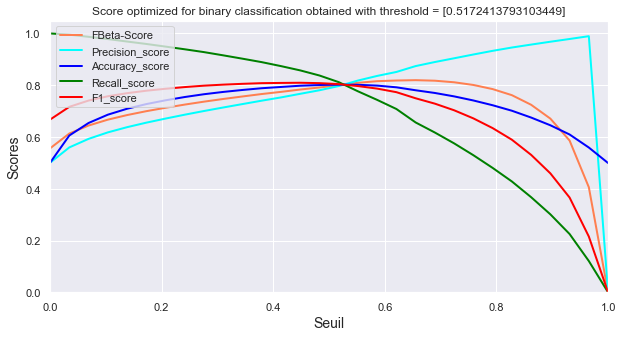

In [123]:
store_score_thresholds = pd.DataFrame(columns = thresholds_column_names)
seuils = np.linspace(0.0, 1.0, num = 30)
store_score_thresholds = predict_threshold(model_Glove,model_name,thresholds_column_names,X_train_ready,y_train,seuils, beta = 0.5, binary_predict=False, predict_proba_OK=False)

seuil is = [0.5172413793103449]


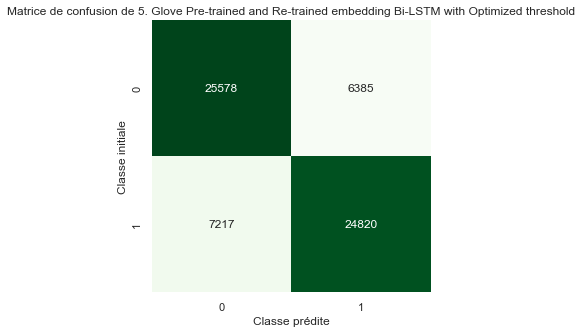

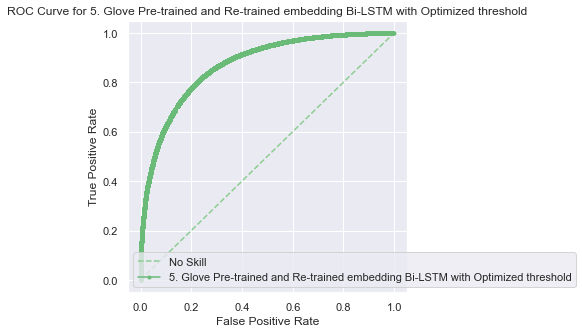

In [125]:
model_name="5. Glove Pre-trained and Re-trained embedding Bi-LSTM with Optimized threshold"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

seuil=store_score_thresholds.loc[(store_score_thresholds['Accuracy_score'] == store_score_thresholds['Accuracy_score'].max()), 'seuil'].values
print(f'seuil is = {seuil}')
binary_transform = True

score_results_stored = evaluation(model_Glove_updated, model_name, score_column_names, X_test_ready, y_test, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

In [126]:
#store_score_thresholds
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,<tensorflow.python.keras.engine.functional.Fun...,1. 1D ConvNet,0.5,0.778856,0.770015,0.794051,0.764232,0.774281,0.857541
1,<tensorflow.python.keras.engine.functional.Fun...,2. LTSM Bidirect,0.5,0.786167,0.780301,0.796142,0.776438,0.783203,0.867276
2,<tensorflow.python.keras.engine.functional.Fun...,3. Glove Pre-trained embedding,0.5,0.782341,0.772055,0.800106,0.765347,0.777141,0.862803
3,<tensorflow.python.keras.engine.functional.Fun...,4. Glove Pre-trained and Re-trained embedding ...,0.5,0.787249,0.789687,0.783219,0.791321,0.788094,0.871671
4,<tensorflow.python.keras.engine.functional.Fun...,5. Glove Pre-trained and Re-trained embedding ...,[0.5172413793103449],0.784921,0.791166,0.774729,0.795385,0.787469,0.871671


## B.3. Modèle avec pré-Entrainement - Transfer Learning à partir du Modèle Fasttext - Sans Mise à jour des plongements

Nous allons ici utilisé des Embeddings pré-entrainé:

Librairies  utilisée: [Librairie FastText](https://fasttext.cc/)
 
Autres librairies non-sollicitées ici:
 - [FastText GitHub](https://github.com/facebookresearch/fastText)
 - [Cours OC](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855006-effectuez-des-plongements-de-mots-word-embeddings)

### B.x.0. Chargement du Word Embedding (Plongement des mots) Fasttext pré-entrainé

In [127]:
#Glove: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#load the entire GloVe word embedding file into memory as a dictionary of word to embedding array

embeddings_index_Fasttext = dict()
DATA_FASTTEXT = os.path.join(src_path, "Pre-Trained_Embedding", "wiki-news-300d-1M.vec", "wiki-news-300d-1M.vec")
Fasttext_File = open(DATA_FASTTEXT, encoding="utf8") #
#Fasttext_File = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
for line in Fasttext_File:
    values_Fasttext = line.split()
    word_Fasttext = values_Fasttext[0]
    coefs_Fasttext = np.asarray(values_Fasttext[1:], dtype='float32')
    embeddings_index_Fasttext[word] = coefs_Fasttext
Fasttext_File.close()
print('Loaded %s word vectors.' % len(embeddings_index_Fasttext))

Loaded 999995 word vectors.


In [128]:
# create a matrix of one embedding for each word in the training dataset
embedding_matrix_Fasttext = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector_Fasttext = embeddings_index_Fasttext.get(word_Fasttext)
    if embedding_vector_Fasttext is not None:
        embedding_matrix_Fasttext[i] = embedding_vector_Fasttext

In [129]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_Fasttext, axis=1))
nonzero_elements / vocab_size

0.5144086340540741

### B.3.1. Architecture du modèle

In [130]:
model_name="6. Fasttext Pre-trained embedding"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

# A integer input for vocab indices.
#inputs = tf.keras.Input(shape=(None,), dtype="int64")
inputs = tf.keras.Input(shape=(maxlen,), dtype='int32')
sequences = layers.Embedding(vocab_size, 300, weights=[embedding_matrix_Fasttext], input_length=maxlen, trainable=False)(inputs)

x = layers.SpatialDropout1D(0.2)(sequences)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# Add 2 bidirectional LSTMs
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x) #(1, activation='sigmoid')

predictions = layers.Dense(1, activation='sigmoid')(x)

model_Fasttext = keras.Model(inputs, predictions)

model_Fasttext.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 30, 300)           24266700  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)             

### B.3.2. Compilation du modèle et choix de la métrique
Nous utilisons la méthode d'optimisiation [adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), qui effectue une descente de gradient.

In [131]:
# Compile the model with binary crossentropy loss and an adam optimizer.
model_Fasttext.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #'mean_squared_error' si problème de regression

#model_Glove.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=tf.metrics.SparseCategoricalAccuracy(),
#             )

# summarize the model
print(model_Fasttext.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 30, 300)           24266700  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)             

### B.3.3. Entrainement du modèle

In [132]:
epochs = 10 #(epochs = Nombre de parcours de phase d'apprentissage)

# Fit the model using the train and test datasets.
history = model_Fasttext.fit(X_train_ready, y_train, 
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_ready, y_test),
                    #batch_size = 128,
                    callbacks = callbacks,
                    workers = 3
                   )

model_Fasttext.save(model_file_path)


Epoch 00001: val_accuracy did not improve from 0.78864

Epoch 00002: val_accuracy did not improve from 0.78864

Epoch 00003: val_accuracy did not improve from 0.78864

Epoch 00004: val_accuracy did not improve from 0.78864

Epoch 00005: val_accuracy did not improve from 0.78864

Epoch 00006: val_accuracy did not improve from 0.78864

Epoch 00007: val_accuracy did not improve from 0.78864

Epoch 00008: val_accuracy did not improve from 0.78864

Epoch 00009: val_accuracy did not improve from 0.78864

Epoch 00010: val_accuracy did not improve from 0.78864

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00010: early stopping


### B.3.4. Evaluation du modèle

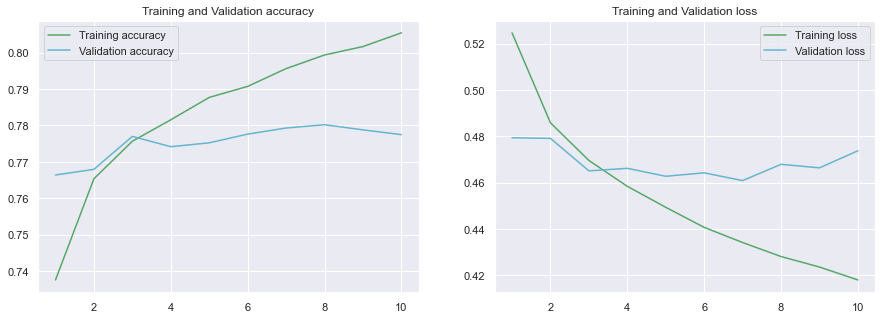

In [133]:
plot_history(history)

Nous notons ici qu'il y a bien un risque de sur-apprentissage, à la vue de l'écart qui se créé.

Ce modèle réussit bien à apprendre avec une précision qui s'approche des 80% en 8 Epochs.
La précision de Validation augmente pendant 3 Epochs, puis se stabilise.

Au delà de 3 Epochs, le risque de sur-apprentissage est croissant, et les explications communes sont:

    - Erreur de Code (Fuite de données)
    - Sur-Apprentissage dû à des différences entre les jeux de données d'entrainement et de validation
    - Classification aléatoire (changeantes entre  les jeux de données d'entrainement et de validation)

Voir l'article [StackOverflow](https://stackoverflow.com/questions/44616841/what-does-it-mean-when-train-and-validation-loss-diverge-from-epoch-1)

In [134]:
# evaluate the model
loss, accuracy = model_Fasttext.evaluate(X_test_ready, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

Accuracy: 77.745312
Loss: 47.374907


### B.3.5. Prédiction et Performance du modèle

In [135]:
y_prob = model_Fasttext.predict(X_test_ready)
y_pred = np.where(y_prob > 0.5, 1, 0)
y_pred = y_pred.astype(int)
y_prob
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

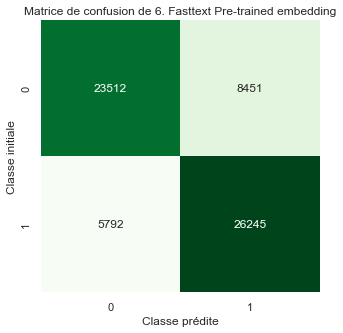

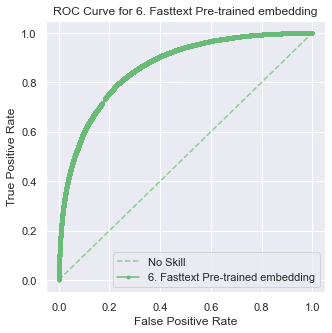

In [136]:
seuil=0.5
binary_transform = True

score_results_stored = evaluation(model_Fasttext, model_name, score_column_names, X_test_ready, y_test, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)


### B.3.6 Optimisation du seuil de décision

20/20 [==============================] - 12s 616ms/step
Roc_AUC_score = 0.9122719282337703


C:\Users\blanc\anaconda3\envs\IA_Project7_Sentiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The optimized threshold for Accuracy is : [0.5862068965517241]


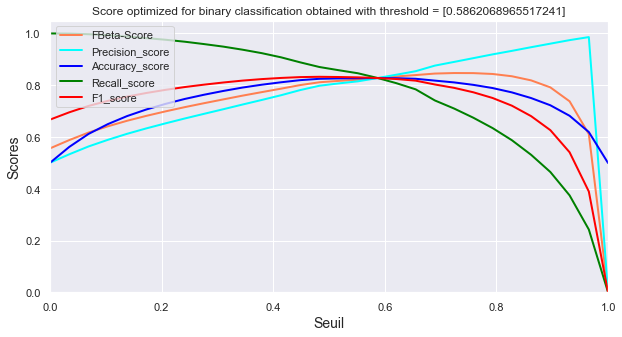

In [137]:
store_score_thresholds = pd.DataFrame(columns = thresholds_column_names)
seuils = np.linspace(0.0, 1.0, num = 30)
store_score_thresholds = predict_threshold(model_Fasttext,model_name,thresholds_column_names,X_train_ready,y_train,seuils, beta = 0.5, binary_predict=False, predict_proba_OK=False)

seuil is = [0.5862068965517241]


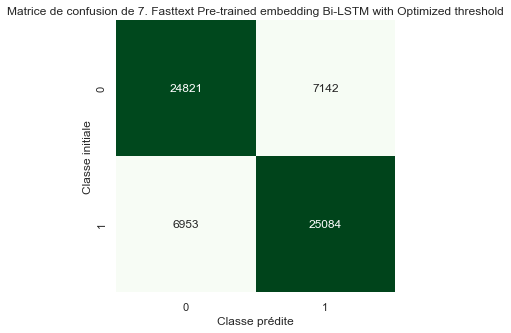

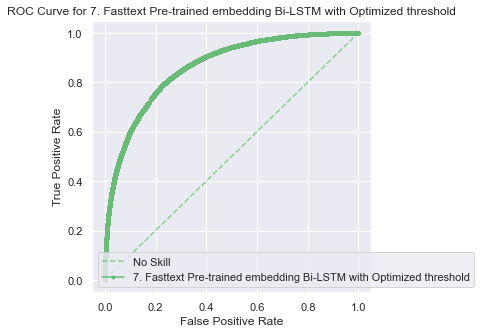

In [138]:
model_name="7. Fasttext Pre-trained embedding Bi-LSTM with Optimized threshold"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

seuil=store_score_thresholds.loc[(store_score_thresholds['Accuracy_score'] == store_score_thresholds['Accuracy_score'].max()), 'seuil'].values
print(f'seuil is = {seuil}')
binary_transform = True

score_results_stored = evaluation(model_Fasttext, model_name, score_column_names, X_test_ready, y_test, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

In [139]:
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,<tensorflow.python.keras.engine.functional.Fun...,1. 1D ConvNet,0.5,0.778856,0.770015,0.794051,0.764232,0.774281,0.857541
1,<tensorflow.python.keras.engine.functional.Fun...,2. LTSM Bidirect,0.5,0.786167,0.780301,0.796142,0.776438,0.783203,0.867276
2,<tensorflow.python.keras.engine.functional.Fun...,3. Glove Pre-trained embedding,0.5,0.782341,0.772055,0.800106,0.765347,0.777141,0.862803
3,<tensorflow.python.keras.engine.functional.Fun...,4. Glove Pre-trained and Re-trained embedding ...,0.5,0.787249,0.789687,0.783219,0.791321,0.788094,0.871671
4,<tensorflow.python.keras.engine.functional.Fun...,5. Glove Pre-trained and Re-trained embedding ...,[0.5172413793103449],0.784921,0.791166,0.774729,0.795385,0.787469,0.871671
5,<tensorflow.python.keras.engine.functional.Fun...,6. Fasttext Pre-trained embedding,0.5,0.786567,0.768202,0.819209,0.756427,0.777453,0.862956
6,<tensorflow.python.keras.engine.functional.Fun...,7. Fasttext Pre-trained embedding Bi-LSTM with...,[0.5862068965517241],0.780667,0.779292,0.78297,0.778378,0.779766,0.862956


## B.4. Modèle avec pré-Entrainement - Transfer Learning à partir du Modèle Fasttext - Avec Mise à jour des plongements

Dans la suite de l'exercice, nous allons mettre à jour nos plongements (embedding), avec le LSTM vu précedemment.

### B.4.1. Architecture du modèle

In [140]:
model_name="8. Fasttext Re-trained embedding Bi-LSTM"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

# A integer input for vocab indices.
#inputs = tf.keras.Input(shape=(None,), dtype="int64")
inputs = tf.keras.Input(shape=(maxlen,), dtype='int32')
sequences = layers.Embedding(vocab_size, 300, weights=[embedding_matrix_Fasttext], input_length=maxlen, trainable=True)(inputs)

x = layers.SpatialDropout1D(0.2)(sequences)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# Add 2 bidirectional LSTMs
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x) #(1, activation='sigmoid')

predictions = layers.Dense(1, activation='sigmoid')(x)

model_Fasttext_updated = keras.Model(inputs, predictions)

model_Fasttext_updated.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 30, 300)           24266700  
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)             

### B.4.2. Compilation du modèle et choix de la métrique
Nous utilisons la méthode d'optimisiation [adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), qui effectue une descente de gradient.

In [141]:
# Compile the model with binary crossentropy loss and an adam optimizer.
model_Fasttext_updated.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #'mean_squared_error' si problème de regression

#model_Glove.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=tf.metrics.SparseCategoricalAccuracy(),
#             )

# summarize the model
print(model_Fasttext_updated.summary())

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 30, 300)           24266700  
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)             

### B.4.3. Entrainement du modèle

In [142]:
epochs = 10 #(epochs = Nombre de parcours de phase d'apprentissage)

# Fit the model using the train and test datasets.
history = model_Fasttext_updated.fit(X_train_ready, y_train, 
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_ready, y_test),
                    #batch_size = 128,
                    callbacks = callbacks,
                    workers = 3
                   )


model_Fasttext_updated.save(model_file_path)


Epoch 00001: val_accuracy did not improve from 0.78864

Epoch 00002: val_accuracy did not improve from 0.78864

Epoch 00003: val_accuracy did not improve from 0.78864

Epoch 00004: val_accuracy did not improve from 0.78864

Epoch 00005: val_accuracy did not improve from 0.78864

Epoch 00006: val_accuracy did not improve from 0.78864

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00006: early stopping


### B.4.4. Evaluation du modèle

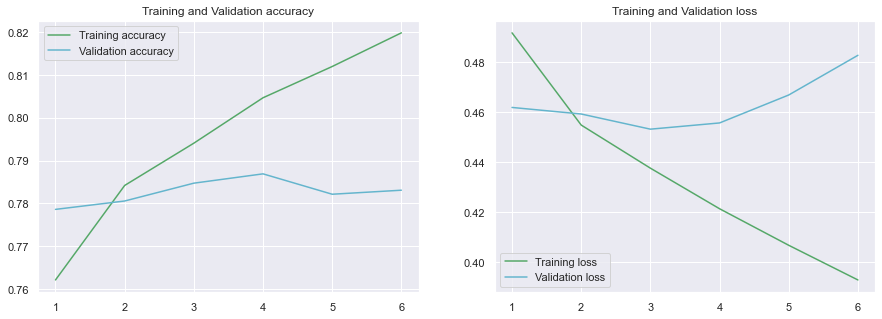

In [143]:
plot_history(history)

Nous notons ici qu'il y a bien un risque de sur-apprentissage, à la vue de l'écart qui se créé.

Ce modèle réussit bien à apprendre avec une précision qui s'approche des 82% en 6 Epochs.
La précision de Validation augmente pendant 3 Epochs, puis se stabilise.

Au delà de 3 Epochs, le risque de sur-apprentissage est croissant, et les explications communes sont:

    - Erreur de Code (Fuite de données)
    - Sur-Apprentissage dû à des différences entre les jeux de données d'entrainement et de validation
    - Classification aléatoire (changeantes entre  les jeux de données d'entrainement et de validation)

Voir l'article [StackOverflow](https://stackoverflow.com/questions/44616841/what-does-it-mean-when-train-and-validation-loss-diverge-from-epoch-1)

In [144]:
# evaluate the model
loss, accuracy = model_Fasttext_updated.evaluate(X_test_ready, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

Accuracy: 78.309375
Loss: 48.267978


### B.4.5. Prédiction et Performance du modèle

In [145]:
y_prob = model_Fasttext_updated.predict(X_test_ready)
y_pred = np.where(y_prob > 0.5, 1, 0)
y_pred = y_pred.astype(int)
y_prob
y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

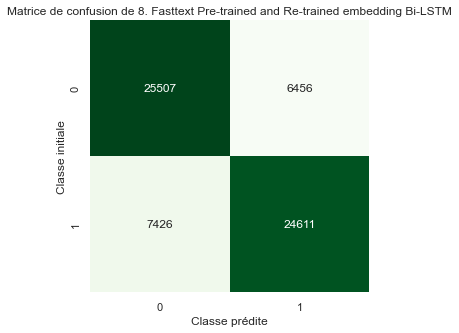

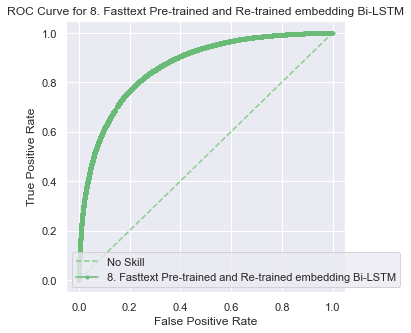

In [146]:
seuil=0.5
binary_transform = True

score_results_stored = evaluation(model_Fasttext_updated, model_name, score_column_names, X_test_ready, y_test, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)


In [147]:
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,<tensorflow.python.keras.engine.functional.Fun...,1. 1D ConvNet,0.5,0.778856,0.770015,0.794051,0.764232,0.774281,0.857541
1,<tensorflow.python.keras.engine.functional.Fun...,2. LTSM Bidirect,0.5,0.786167,0.780301,0.796142,0.776438,0.783203,0.867276
2,<tensorflow.python.keras.engine.functional.Fun...,3. Glove Pre-trained embedding,0.5,0.782341,0.772055,0.800106,0.765347,0.777141,0.862803
3,<tensorflow.python.keras.engine.functional.Fun...,4. Glove Pre-trained and Re-trained embedding ...,0.5,0.787249,0.789687,0.783219,0.791321,0.788094,0.871671
4,<tensorflow.python.keras.engine.functional.Fun...,5. Glove Pre-trained and Re-trained embedding ...,[0.5172413793103449],0.784921,0.791166,0.774729,0.795385,0.787469,0.871671
5,<tensorflow.python.keras.engine.functional.Fun...,6. Fasttext Pre-trained embedding,0.5,0.786567,0.768202,0.819209,0.756427,0.777453,0.862956
6,<tensorflow.python.keras.engine.functional.Fun...,7. Fasttext Pre-trained embedding Bi-LSTM with...,[0.5862068965517241],0.780667,0.779292,0.78297,0.778378,0.779766,0.862956
7,<tensorflow.python.keras.engine.functional.Fun...,8. Fasttext Pre-trained and Re-trained embeddi...,0.5,0.780014,0.787275,0.768206,0.792191,0.783094,0.866065


### B.4.6 Optimisation du seuil de décision

20/20 [==============================] - 13s 630ms/step
Roc_AUC_score = 0.9284876702904281


C:\Users\blanc\anaconda3\envs\IA_Project7_Sentiment\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The optimized threshold for Accuracy is : [0.4482758620689655]


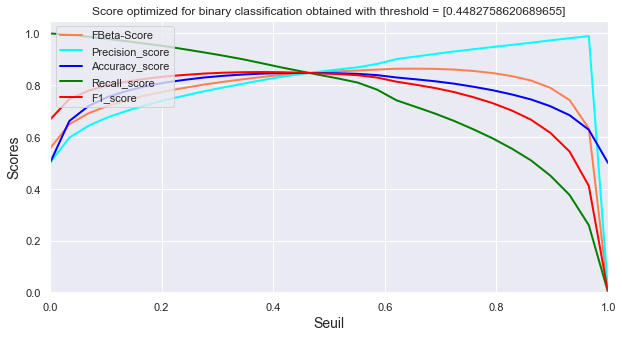

In [148]:
store_score_thresholds = pd.DataFrame(columns = thresholds_column_names)
seuils = np.linspace(0.0, 1.0, num = 30)
store_score_thresholds = predict_threshold(model_Fasttext_updated,model_name,thresholds_column_names,X_train_ready,y_train,seuils, beta = 0.5, binary_predict=False, predict_proba_OK=False)

seuil is = [0.4482758620689655]


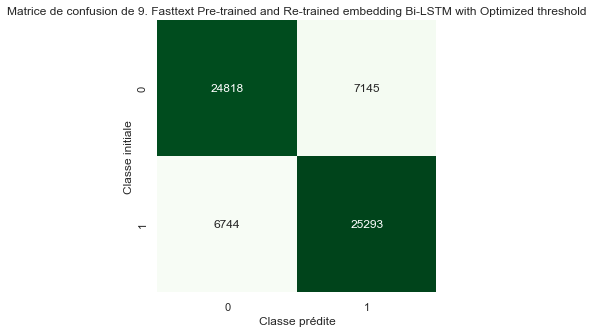

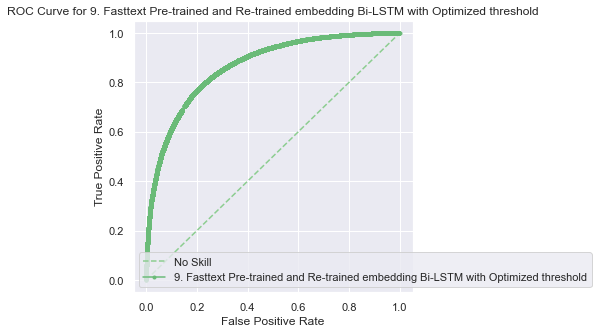

In [149]:
model_name="9. Fasttext Pre-trained and Re-trained embedding Bi-LSTM with Optimized threshold"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

seuil=store_score_thresholds.loc[(store_score_thresholds['Accuracy_score'] == store_score_thresholds['Accuracy_score'].max()), 'seuil'].values
print(f'seuil is = {seuil}')
binary_transform = True

score_results_stored = evaluation(model_Fasttext_updated, model_name, score_column_names, X_test_ready, y_test, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

In [32]:
#store_score
store_score.sort_values(by=['Accuracy_score'], ascending=False)

NameError: name 'store_score' is not defined

## Conclusions sur les Modèles de réseau de neurones

Nous avons comparé différent modèle des réseaux de neurones:
 - Modèle sans pré-entrainement
 - Modèle avec pre-entrainement (Transfer Learning)
 - Modèle avec pre-entrainement + Ré-entrainement (Transfer Learning)

Le modèle le plus performant obtenu est un modèle faisant appel au Transfer learning, qui utilise les vecteurs de plongements (Embedding Layer) Glove.
Les performances de celui-ci ont encore été amélioré avec un ré-entrainement sur notre jeu d'entrainement.

Il est cependant préférable de conserver le seuil de décision à 0.5.


In [30]:
plot_model_result(store_score, "Accuracy_score", "Model Name")

NameError: name 'store_score' is not defined

## Augmentation de la taille du jeu de donnée

In [6]:
### DATASET PREPARATION = CREER UN PIPELINE !!!!!!!!!!!!!!

#clean_df = clean_data(df.groupby('target').apply(lambda x: x.sample(frac=0.08))) #clean_data(df)
clean_df2 = df.sample(frac=0.5, random_state=0)
clean_df2 = clean_df2.drop(['id', 'date', 'flag', 'user', 'target_string', 'date_format'], axis=1)

#Replace Target value related to positive statement = 1 (Binary reason)
clean_df2.loc[clean_df2['target'] == 4, 'target'] = 1

#Technique 2 : Text preprocess using https://pypi.org/project/tweet-preprocessor/
clean_df2.text = clean_df2.text.apply(lambda x: p.clean(x))

In [7]:
#Séparation des jeux de données
#Define 20% of dataset as Test dataset
X_train2, X_test2, y_train2, y_test2 = train_test_split(clean_df2['text'], clean_df2['target'], test_size=0.2, random_state=0, stratify=clean_df2['target'])
#Define 20% (=25% * 80%) of dataset as Val dataset, and 60% as Train dataset
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0, stratify=y_train)

In [10]:
tokenizer2 = Tokenizer(num_words = 1000)
#Sérialisatioon du tokenizer pour une réutilisation future
tokenizer2.fit_on_texts(X_train2)

dictionary2 = tokenizer2.word_index
vocab_size2 = len(dictionary2) + 1
print("Vocabulary Size :", vocab_size2)

X_train_enc2 = tokenizer2.texts_to_sequences(X_train2)
X_test_enc2 = tokenizer2.texts_to_sequences(X_test2)

#Nous définissons la longueur des séquences (Ici 30 Mots)
maxlen = 30
X_train_ready2 = pad_sequences(X_train_enc2, maxlen = maxlen, padding='post')
X_test_ready2 = pad_sequences(X_test_enc2, maxlen = maxlen, padding='post')
print("Training X_train_ready2 Shape:",X_train_ready2.shape)
print("Testing X_test_ready2 Shape:",X_test_ready2.shape)

y_train2 = np.asarray(y_train2).astype('float32').reshape(-1,1)
y_test2 = np.asarray(y_test2).astype('float32').reshape(-1,1)
print("y_train2 shape:", y_train2.shape)
print("y_test2 shape:", y_test2.shape)

Vocabulary Size : 167908
Training X_train_ready2 Shape: (640000, 30)
Testing X_test_ready2 Shape: (160000, 30)
y_train2 shape: (640000, 1)
y_test2 shape: (160000, 1)


In [168]:
file = open('./Models/tokenizer2.pickle','wb')
pickle.dump(tokenizer2, file)
file.close()
#save vectoriser_stem model in joblib files
dump(tokenizer, './Models/tokenizer2.joblib')


['./Models/tokenizer2.joblib']

In [13]:
# create a matrix of one embedding for each word in the training dataset
embedding_matrix_Glove2 = np.zeros((vocab_size2, 100))
for word, i in tokenizer2.word_index.items():
    embedding_vector_Glove2 = embeddings_index_Glove.get(word)
    if embedding_vector_Glove2 is not None:
        embedding_matrix_Glove2[i] = embedding_vector_Glove2

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_Glove2, axis=1))
nonzero_elements / vocab_size2

0.5320115777687782

In [14]:
model_name="4. Glove Re-trained embedding Bi-LSTM BigData"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

# A integer input for vocab indices.
#inputs = tf.keras.Input(shape=(None,), dtype="int64")
inputs = tf.keras.Input(shape=(maxlen,), dtype='int32')
sequences = layers.Embedding(vocab_size2, 100, weights=[embedding_matrix_Glove2], input_length=maxlen, trainable=True)(inputs)

x = layers.SpatialDropout1D(0.2)(sequences)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# Add 2 bidirectional LSTMs
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x) #(1, activation='sigmoid')

predictions = layers.Dense(1, activation='sigmoid')(x)

model_Glove_updated_big_data = keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model_Glove_updated_big_data.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #'mean_squared_error' si problème de regression

# summarize the model
print(model_Glove_updated_big_data.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 100)           16790800  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            32064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [17]:
epochs = 10 #(epochs = Nombre de parcours de phase d'apprentissage)

# Fit the model using the train and test datasets.
history = model_Glove_updated_big_data.fit(X_train_ready2, y_train2, 
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_ready2, y_test2),
                    #batch_size = 128,
                    callbacks = callbacks,
                    workers = 3
                   )

#model_Glove_updated_big_data.save(model_file_path)


Epoch 00001: val_accuracy improved from -inf to 0.78178, saving model to ./Models\checkpoint

Epoch 00002: val_accuracy improved from 0.78178 to 0.78956, saving model to ./Models\checkpoint

Epoch 00003: val_accuracy improved from 0.78956 to 0.79167, saving model to ./Models\checkpoint

Epoch 00004: val_accuracy improved from 0.79167 to 0.79304, saving model to ./Models\checkpoint

Epoch 00005: val_accuracy improved from 0.79304 to 0.79510, saving model to ./Models\checkpoint

Epoch 00006: val_accuracy did not improve from 0.79510

Epoch 00007: val_accuracy did not improve from 0.79510

Epoch 00008: val_accuracy did not improve from 0.79510

Epoch 00009: val_accuracy improved from 0.79510 to 0.79514, saving model to ./Models\checkpoint

Epoch 00010: val_accuracy did not improve from 0.79514

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


In [27]:
model_name="Best_Model_BigData2"
model_folder_path = './Models'


model_file_path = os.path.join(model_folder_path, model_name)
model_Glove_updated_big_data.save(model_file_path)

INFO:tensorflow:Assets written to: ./Models\Best_Model_BigData2\assets


In [28]:
model_Glove_updated_big_data.save('./Models/Best_Model_BigData3')


INFO:tensorflow:Assets written to: ./Models/Best_Model_BigData3\assets


In [25]:
model_name="Best_Model_BigData"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)
model_Glove_updated_big_data.save(model_file_path, save_format='h5')


Accuracy: 79.376876
Loss: 43.675894


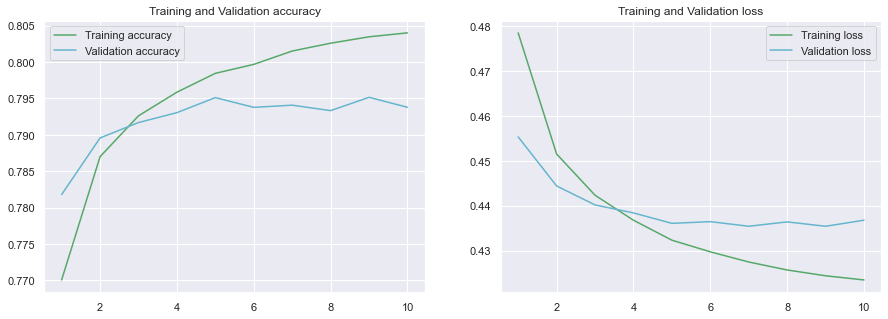

In [29]:
plot_history(history)
# evaluate the model
loss, accuracy = model_Glove_updated_big_data.evaluate(X_test_ready2, y_test2, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

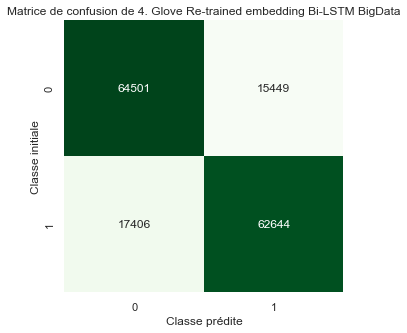

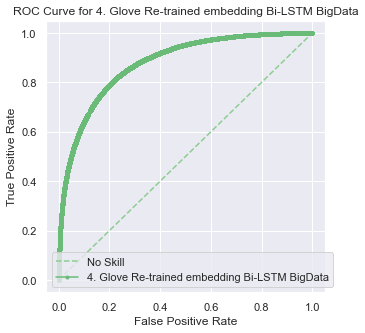

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,<tensorflow.python.keras.engine.functional.Fun...,1. 1D ConvNet,0.5,0.778856,0.770015,0.794051,0.764232,0.774281,0.857541
1,<tensorflow.python.keras.engine.functional.Fun...,2. LTSM Bidirect,0.5,0.786167,0.780301,0.796142,0.776438,0.783203,0.867276
2,<tensorflow.python.keras.engine.functional.Fun...,3. Glove Pre-trained embedding,0.5,0.782341,0.772055,0.800106,0.765347,0.777141,0.862803
3,<tensorflow.python.keras.engine.functional.Fun...,4. Glove Pre-trained and Re-trained embedding ...,0.5,0.787249,0.789687,0.783219,0.791321,0.788094,0.871671
4,<tensorflow.python.keras.engine.functional.Fun...,5. Glove Pre-trained and Re-trained embedding ...,[0.5172413793103449],0.784921,0.791166,0.774729,0.795385,0.787469,0.871671
5,<tensorflow.python.keras.engine.functional.Fun...,6. Fasttext Pre-trained embedding,0.5,0.786567,0.768202,0.819209,0.756427,0.777453,0.862956
6,<tensorflow.python.keras.engine.functional.Fun...,7. Fasttext Pre-trained embedding Bi-LSTM with...,[0.5862068965517241],0.780667,0.779292,0.78297,0.778378,0.779766,0.862956
7,<tensorflow.python.keras.engine.functional.Fun...,8. Fasttext Pre-trained and Re-trained embeddi...,0.5,0.780014,0.787275,0.768206,0.792191,0.783094,0.866065
8,<tensorflow.python.keras.engine.functional.Fun...,9. Fasttext Pre-trained and Re-trained embeddi...,[0.4482758620689655],0.784583,0.781666,0.789493,0.779734,0.782984,0.866065
9,<tensorflow.python.keras.engine.functional.Fun...,4. Glove Re-trained embedding Bi-LSTM BigData,0.5,0.792245,0.798171,0.782561,0.802172,0.794656,0.878792


In [198]:
seuil=0.5
binary_transform = True

score_results_stored = evaluation(model_Glove_updated_big_data, model_name, score_column_names, X_test_ready2, y_test2, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)
store_score

In [202]:
store_score.sort_values(by=['Accuracy_score'], ascending=False)

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
9,<tensorflow.python.keras.engine.functional.Fun...,4. Glove Re-trained embedding Bi-LSTM BigData,0.5,0.792245,0.798171,0.782561,0.802172,0.794656,0.878792
3,<tensorflow.python.keras.engine.functional.Fun...,4. Glove Pre-trained and Re-trained embedding ...,0.5,0.787249,0.789687,0.783219,0.791321,0.788094,0.871671
4,<tensorflow.python.keras.engine.functional.Fun...,5. Glove Pre-trained and Re-trained embedding ...,[0.5172413793103449],0.784921,0.791166,0.774729,0.795385,0.787469,0.871671
1,<tensorflow.python.keras.engine.functional.Fun...,2. LTSM Bidirect,0.5,0.786167,0.780301,0.796142,0.776438,0.783203,0.867276
7,<tensorflow.python.keras.engine.functional.Fun...,8. Fasttext Pre-trained and Re-trained embeddi...,0.5,0.780014,0.787275,0.768206,0.792191,0.783094,0.866065
8,<tensorflow.python.keras.engine.functional.Fun...,9. Fasttext Pre-trained and Re-trained embeddi...,[0.4482758620689655],0.784583,0.781666,0.789493,0.779734,0.782984,0.866065
6,<tensorflow.python.keras.engine.functional.Fun...,7. Fasttext Pre-trained embedding Bi-LSTM with...,[0.5862068965517241],0.780667,0.779292,0.78297,0.778378,0.779766,0.862956
5,<tensorflow.python.keras.engine.functional.Fun...,6. Fasttext Pre-trained embedding,0.5,0.786567,0.768202,0.819209,0.756427,0.777453,0.862956
2,<tensorflow.python.keras.engine.functional.Fun...,3. Glove Pre-trained embedding,0.5,0.782341,0.772055,0.800106,0.765347,0.777141,0.862803
0,<tensorflow.python.keras.engine.functional.Fun...,1. 1D ConvNet,0.5,0.778856,0.770015,0.794051,0.764232,0.774281,0.857541


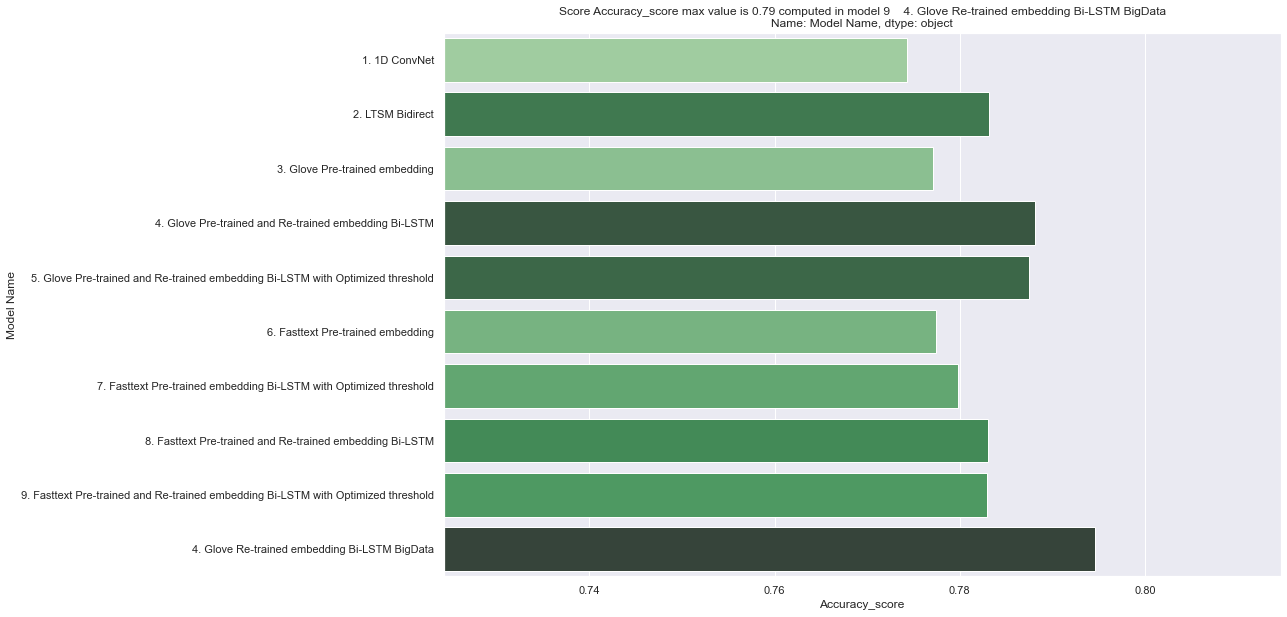

In [200]:
#plot_model_result(store_score, "Accuracy_score", "Model Name")
plot_model_result(store_score.sort_values(by=['Accuracy_score'], ascending=False).head(5), "Accuracy_score", "Model Name")


## Transfer Learning à partir du Modèle BERT

BERT pour Bidirectional Encoder Representations from Transformers

[Blog BERT](https://lesdieuxducode.com/blog/2019/4/bert--le-transformer-model-qui-sentraine-et-qui-represente)

[BERT Text Classification](https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d)

[GitHub BERT](https://github.com/google-research/bert)

[Documentation BERT Transformers - Fine-Tune for Text classification](https://huggingface.co/docs/transformers/tasks/sequence_classification)

__Données:__

Nous allons utiliser le même jeu de données que sur le notebook précedent (Modèles Simple et Avancé).

__Traitement des données:__

Nous adapterons le pre-processing des données afin qu'il rende notre modèle BERT le plus performant possible.
Nous évaluerons ainsi plusieurs méthode des pré-traitement.

__Modèles de Réseaux de Neurones:__

Nous réaliserons plusieurs technique de plongements de mots, et choisierons le modèle le plus performant.
Nous adapterons les hyperparamètres des modèles d'apprentissage, afin de visualiser les variations des scores.
Nous travaillerons sur le seuil de décisions afin de visualiser les variations des résultats.



### Préparation des données

In [12]:

# Convert Pandas DataFrames with Dataset.from_pandas() to match with HuggingFace librairies
dataset = Dataset.from_pandas(clean_df)
dataset

Dataset({
    features: ['target', 'text', '__index_level_0__'],
    num_rows: 32000
})

In [14]:
# Rename column
dataset = dataset.rename_column("target", "labels")

# Remove column
dataset = dataset.remove_columns("__index_level_0__")
dataset

Dataset({
    features: ['labels', 'text'],
    num_rows: 32000
})

In [17]:
# Creates train and test splits
# https://huggingface.co/docs/datasets/process#split
dataset = dataset.train_test_split(test_size=0.2, seed=0) #, stratify_by_column="labels"
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 25600
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 6400
    })
})

In [18]:
dataset['train'][0]

{'labels': 0,
 'text': "Totally frustrated!!!! Well, at least this loss wasn't as bad as the last--Hedo did his part. Anyone know what's up with D. Howard??"}

### Classification de texte avec les transfromers BERT HuggingFace

[Documentation ici](https://huggingface.co/docs/transformers/tasks/sequence_classification#preprocess)

Ici, nous allons utiliser le tokenizer "transformers" pour processer le texte. Nous incluons une strategie de padding et de tronquage pour mieux gérer kes différences de longueures de texte.


In [21]:

# Load the DistilBERT tokenizer to process the text field:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case = True)
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case = True)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
# preprocessing function to tokenize text and truncate sequences to be no longer than DistilBERT’s maximum input length
def preprocess_function(dataset):
    return tokenizer(dataset["text"], truncation=True, padding=True) #'max_length', return_tensors="tf"

#Set the padding parameter to True to pad the shorter sequences in the batch to match the longest sequence:
#Set the truncation parameter to True to truncate a sequence to the maximum length accepted by the model

In [23]:
#Datasets map function to apply the preprocessing function over the entire dataset.
tokenized_sentiment = dataset.map(preprocess_function, batched=True)

100%|██████████| 7/7 [00:01<00:00,  5.59ba/s]


In [24]:
#Apply function on text, we just use the map method of our dataset objec, and return ['labels', 'text', 'input_ids', ('token_type_ids',) 'attention_mask']
tokenized_sentiment

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25600
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6400
    })
})

In [26]:
from transformers import DataCollatorWithPadding
#  DataCollatorWithPadding to create a batch of examples
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#### Train the model

Ici, nous utilisons la class trainer pour optimiser l'[entrainement de notre modèle transformers](https://huggingface.co/docs/transformers/training#train).

Nous chargeons notre modèle et nous spécifions le nombre de label attendus (Ici 2 = 0 ou 1)


In [29]:
model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) #("distilbert-base-uncased", num_labels=2)
#model_bert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# Load BERT models along with the number of expected labels:
#model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) #("distilbert-base-uncased", num_labels=2)
#model_bert = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
#model_bert = TFAutoModel.from_pretrained("bert-base-uncased", num_labels=2)
#model_bert = TFBertModel.from_pretrained("bert-base-uncased", num_labels=2)
#model_bert = TFDistilBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Training hyperparameters (Phase décrite dans How-To-Guides)

Nous crééons les Arguments du modèle d'entrainement, avec les hyperparamètres à ajuster, ainsi que les drapeaux pour activer les options.

Ici, nous commenceons avec les [default training hyperparameters](https://huggingface.co/docs/transformers/training#training-hyperparameters).

Nous spécifions également le dossier de stockage **des checkpoints = ./bert_results/**

In [30]:
# Define your training hyperparameters in TrainingArguments.
training_args = TrainingArguments(
    output_dir="./bert_results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)


#### Trainer

Créer un objet Trainer avec notre modèle, nos arguments et nos datasets et fonctions d'évaluation.

In [31]:
# Pass the training arguments to Trainer along with the model, dataset, tokenizer, and data collator.
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=tokenized_sentiment["train"],
    eval_dataset=tokenized_sentiment["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [32]:
trainer.train()

Step,Training Loss
500,0.588500
1000,0.482300
1500,0.444700
2000,0.433500
2500,0.432700
3000,0.416700
3500,0.372800
4000,0.339400
4500,0.331200
5000,0.345900


TrainOutput(global_step=16000, training_loss=0.2458859944343567, metrics={'train_runtime': 8059.6044, 'train_samples_per_second': 1.985, 'total_flos': 0, 'epoch': 5.0})

In [40]:
trainer.evaluate(tokenized_sentiment["test"])

{'eval_loss': 1.080580234527588,
 'eval_runtime': 79.8584,
 'eval_samples_per_second': 80.142,
 'epoch': 5.0}

#### Predict
La sortie de la commande predict est un Tuple contenant 3 champs: predictions, label_ids, and metrics.

[Refer to HuggingFace doc](https://huggingface.co/course/chapter3/3?fw=pt#evaluation)

La prédiction est un tableau à 2 dimensions. Nous devons prendre l'index avec la valeur maximum du 2eme axes.

In [33]:
y_prob = trainer.predict(tokenized_sentiment["test"]) #test_text
#y_prob[0]
y_pred = np.argmax(y_prob.predictions, axis=-1)
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [34]:
print(y_prob.predictions.shape, y_prob.label_ids.shape)

(6400, 2) (6400,)


In [35]:
y_prob[2]

{'test_loss': 1.080580234527588,
 'test_runtime': 101.4888,
 'test_samples_per_second': 63.061}

In [36]:
y_prob[0][:10]

array([[ 3.0826626 , -3.6068494 ],
       [ 3.1071796 , -3.6364894 ],
       [ 3.5390444 , -3.8031054 ],
       [ 3.6616302 , -3.786799  ],
       [-4.2102375 ,  4.300715  ],
       [ 0.08834158,  0.03472881],
       [ 3.3118718 , -3.7403247 ],
       [-3.7819226 ,  4.12813   ],
       [-4.0370965 ,  4.1948895 ],
       [ 2.1252117 , -2.6634588 ]], dtype=float32)

In [37]:
y_prob[1][:10]

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [38]:
y_pred[:10]

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [39]:
tokenized_sentiment["test"]["labels"][:10]

[0, 0, 0, 0, 1, 1, 0, 1, 1, 1]

In [41]:
print(classification_report(y_prob[1], y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      3251
           1       0.82      0.82      0.82      3149

    accuracy                           0.82      6400
   macro avg       0.82      0.82      0.82      6400
weighted avg       0.82      0.82      0.82      6400



In [42]:
#Initialisation de la table des résultats
score_column_names = ["Model Type","Model Name","seuil","F1-Score","FBeta-Score", "Recall_score", "Precision_score", "Accuracy_score", "Roc_AUC_score"]
store_score = pd.DataFrame(columns = score_column_names)

In [51]:
y_test = dataset["test"]["labels"]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
Roc_AUC_score = auc(false_positive_rate, true_positive_rate)
Roc_AUC_score

0.8227077014386174

In [44]:
F1_score = f1_score(y_prob[1], y_pred)
FBeta_score = fbeta_score(y_prob[1], y_pred, average='binary', beta=0.5, pos_label=1) #make_scorer(fbeta_score, beta = 2, pos_label=0 ,average = 'binary')
Recall_score = recall_score(y_prob[1], y_pred)
Precision_score = precision_score(y_prob[1], y_pred)
Accuracy_score = accuracy_score(y_prob[1], y_pred)

In [46]:
model_name="10. BERT AutoModel - bert-base-uncased"
model_folder_path = './bert_models'
model_file_path = os.path.join(model_folder_path, model_name)
seuil=0.5
binary_transform = True

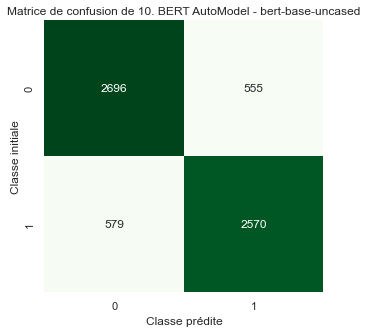

In [47]:
#Plot functions
matrix_pred_model(model_bert, model_name, y_prob[1], y_pred) 
#plot_roc_auc_curve(model_name, false_positive_rate, true_positive_rate)

In [48]:
score_results = pd.Series([model_bert, model_name, seuil, F1_score, FBeta_score, Recall_score, Precision_score, Accuracy_score, Roc_AUC_score])
score_results_stored = pd.DataFrame([score_results.values],  columns = score_column_names)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

In [49]:
store_score

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,BertForSequenceClassification(\n (bert): Bert...,10. BERT AutoModel - bert-base-uncased,0.5,0.819254,0.821139,0.816132,0.8224,0.822812,0.822708


## Transfer Learning à partir du Modèle Word2vec

Nous allons ici utilisé des Embeddings pré-entrainé:

Librairies  utilisée: [Librairie Word2Vec]()
 
Autres librairies non-sollicitées ici:
 
 - [Cours OC](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855006-effectuez-des-plongements-de-mots-word-embeddings)

In [106]:
# Word2vec
#import word2vec
import gensim
from gensim.models import word2vec

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

### 0. Word Embedding (Plongement des mots) Word2Vec  pré-entrainé



In [ ]:
Embedding_dimensions = 100


In [ ]:
# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train_ready))


In [ ]:
# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

In [ ]:
# Defining the model input length.
input_length = maxlen
vocab_length = vocab_size

embedding_matrix = np.zeros((vocab_size, 100))

# create a matrix of one embedding for each word in the training dataset
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[i] = word2vec_model.wv.__getitem__(word)
print("Embedding Matrix Shape:", embedding_matrix.shape)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

Nous vérifions ci-dessus le % de vecteurs de plongements connus dans le modèle pré-entrainé.

Il est de ... %

### Architecture du modèle
Nous définissons l'achitecture du modèle RNN, comme nous l'avions fait précedemment:

1) Embedding Layer - Générer les vecteurs de plongements de mots pour chaque sequence.

3) Conv1D Layer - Couche de convolution permettant de concentrer l'information, et d'apprendre des représentations. [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814661-construisez-des-architectures-neuronales-modulaires#/id/r-6231514)

4) Bi-LSTM - Long Short Term Memory - Réseau de Neurones Récurrentes utile pour l'analyse de séquence multidirectionnelle, capable de modéliser des dépendances à travers le temps [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814656-decouvrez-les-cellules-a-memoire-interne-les-lstm#/id/r-6353610)

4) Dense - Fully Connected Layers - Couche nécessaire à la prise de décision [Voir Cours OC](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning/5814661-construisez-des-architectures-neuronales-modulaires#/id/r-6185547)


Dans l'exemple ci-dessous, nous n'entrainons pas nos plongements à partir du jeu de données de Tweeter.

In [ ]:
model_name="10. Word2Vec Pre-trained embedding"
model_folder_path = './Models'
model_file_path = os.path.join(model_folder_path, model_name)

# A integer input for vocab indices.
#inputs = tf.keras.Input(shape=(None,), dtype="int64")
inputs = tf.keras.Input(shape=(maxlen,), dtype='int32')
sequences = layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)(inputs)

x = layers.SpatialDropout1D(0.2)(sequences)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# Add 2 bidirectional LSTMs
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
#x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x) #(1, activation='sigmoid')

predictions = layers.Dense(1, activation='sigmoid')(x)

model_w2v = keras.Model(inputs, predictions)

model_w2v.summary()

### 2. Compilation du modèle et choix de la métrique
Nous utilisons la méthode d'optimisiation [adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), qui effectue une descente de gradient.

In [ ]:
# Compile the model with binary crossentropy loss and an adam optimizer.
model_w2v.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #'mean_squared_error' si problème de regression

#model_Glove.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=tf.metrics.SparseCategoricalAccuracy(),
#             )

# summarize the model
print(model_w2v.summary())

### 3. Entrainement du modèle

In [ ]:
epochs = 10 #(epochs = Nombre de parcours de phase d'apprentissage)

# Fit the model using the train and test datasets.
history = model_w2v.fit(X_train_ready, y_train, 
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_ready, y_test),
                    #batch_size = 128,
                    callbacks = callbacks,
                    workers = 3
                   )

model_w2v.save(model_file_path)

### 4. Evaluation du modèle

In [ ]:
plot_history(history)

In [ ]:
# evaluate the model
loss, accuracy = model_w2v.evaluate(X_test_ready, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

### 5. Prédiction et Performance du modèle

In [ ]:
y_prob = model_w2v.predict(X_test_ready)
y_pred = np.where(y_prob > 0.5, 1, 0)
y_pred = y_pred.astype(int)
y_prob
y_pred

In [ ]:
seuil=0.5
binary_transform = True

score_results_stored = evaluation(model_w2v, model_name, score_column_names, X_test_ready, y_test, seuil = seuil, binary_predict=False, predict_proba_OK=False)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)
